In [1]:
import os
ROOT_DIR = ".."

import json
with open(f"{ROOT_DIR}/API_KEYS2.json", "r") as file:
    api_keys = json.load(file)

os.environ['OPENAI_API_KEY'] = api_keys['OPENAI_API_KEY']
os.environ['ANTHROPIC_API_KEY'] = api_keys['ANTHROPIC_API_KEY']
os.environ['GOOGLE_API_KEY'] = api_keys['GOOGLE_API_KEY']
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir3')

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import json

import sys; sys.path.append("../src")
import llms
import cholec
import cholecseg8k_utils
from importlib import reload
reload(cholec)
reload(cholecseg8k_utils)
reload(llms)
from cholec import CholecExample, CholecDataset, load_model, items_to_examples
from cholecseg8k_utils import ID2LABEL, LABEL2ID, display_image, example_to_tensors, presence_qas_from_example
from llms import MyOpenAIModel, MyAnthropicModel, MyGoogleModel

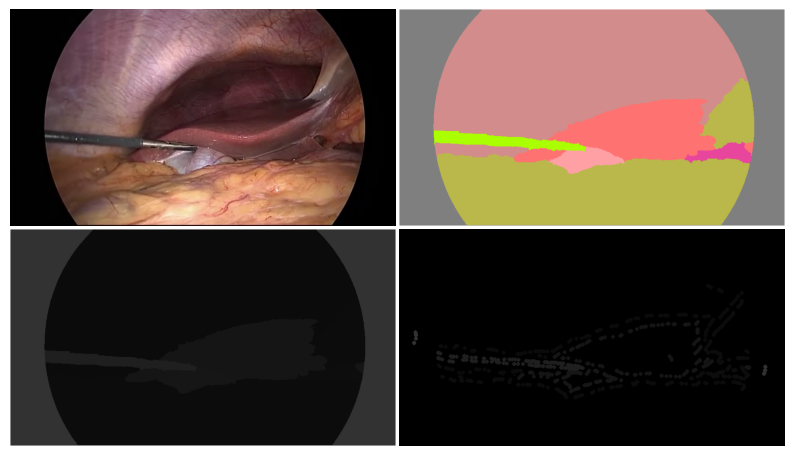

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("minwoosun/CholecSeg8k")

display_image(dataset, 800) # video index from 0 to 8079


In [4]:
# ==== Balanced subset selection (presence vs absence per organ) ====
from pathlib import Path
from typing import List, Tuple, Optional
import numpy as np
import torch
from tqdm.auto import tqdm

# If available, reuse your utils; otherwise define a tiny helper.
try:
    from cholecseg8k_utils import ID2LABEL, example_to_tensors
except Exception:
    ID2LABEL = {
        0:"Black Background",1:"Abdominal Wall",2:"Liver",3:"Gastrointestinal Tract",
        4:"Fat",5:"Grasper",6:"Connective Tissue",7:"Blood",8:"Cystic Duct",
        9:"L-hook Electrocautery",10:"Gallbladder",11:"Hepatic Vein",12:"Liver Ligament"
    }
    # You must define/import example_to_tensors from your earlier cell if this branch runs.

LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]  # 1..12

def labels_to_presence_vector(lab_t: torch.Tensor,
                              ignore_index: int = -1,
                              min_pixels: int = 1) -> torch.LongTensor:
    """Return 12-dim presence for IDs 1..12."""
    if isinstance(lab_t, np.ndarray):
        lab_t = torch.from_numpy(lab_t)
    lab_t = lab_t.to(torch.long)
    valid = lab_t != ignore_index
    flat  = lab_t[valid].view(-1)
    num_classes = max(ID2LABEL.keys()) + 1  # 13
    counts = torch.zeros(num_classes, dtype=torch.long)
    if flat.numel() > 0:
        counts = torch.bincount(flat, minlength=num_classes)
    y = (counts[LABEL_IDS] >= min_pixels).to(torch.long)  # [12]
    return y

def build_presence_matrix(dataset, split: str = "train",
                          indices: Optional[List[int]] = None,
                          min_pixels: int = 1) -> Tuple[np.ndarray, List[int]]:
    """
    Returns:
      Y: np.ndarray [M,12] with 0/1 presence for each organ (IDs 1..12)
      idxs: the dataset indices corresponding to rows of Y
    """
    ds = dataset[split]
    if indices is None:
        indices = list(range(len(ds)))
    rows = []
    idxs = []
    for i in tqdm(indices, desc="Computing presence matrix"):
        ex = ds[i]
        _, lab_t = example_to_tensors(ex)
        y = labels_to_presence_vector(lab_t, min_pixels=min_pixels).cpu().numpy().astype(np.int8)
        rows.append(y); idxs.append(i)
    Y = np.stack(rows, axis=0)  # [M,12]
    return Y, idxs

def select_balanced_indices(Y: np.ndarray, idxs: List[int], n_select: int,
                            seed: int = 0) -> List[int]:
    """
    Greedy selection to minimize total imbalance sum_k |pos_k - neg_k|.
    """
    rng = np.random.default_rng(seed)
    M, K = Y.shape  # K=12
    selected_mask = np.zeros(M, dtype=bool)

    # imbalance bookkeeping
    pos = np.zeros(K, dtype=np.int64)
    neg = np.zeros(K, dtype=np.int64)
    # s_j for a candidate row is 2*y - 1 ∈ {-1,+1}^K (affects imbalance delta)
    S = 2*Y - 1  # [M,K]

    chosen = []
    for _ in tqdm(range(min(n_select, M)), desc="Selecting balanced set"):
        b = pos - neg                     # current signed imbalance [K]
        base_abs = np.abs(b).sum()

        # Try every unselected candidate and compute its improvement:
        # new b' = b + s_row; improvement = sum(|b| - |b'|)
        # Vectorized: for each row r, sum(|b|) - sum(|b + S[r]|)
        candidate_idxs = np.where(~selected_mask)[0]
        if candidate_idxs.size == 0:
            break
        B = b[None, :] + S[candidate_idxs]          # [C,K]
        new_abs = np.abs(B).sum(axis=1)              # [C]
        improvement = base_abs - new_abs             # [C]

        # pick best; tie-break randomly among near-equals
        best_impr = improvement.max()
        # allow a small epsilon tie window
        eps = 1e-9
        ties = candidate_idxs[np.where(improvement >= best_impr - eps)[0]]
        pick_local = rng.choice(ties)
        selected_mask[pick_local] = True
        chosen.append(idxs[pick_local])

        # update imbalance with the picked row
        pos += Y[pick_local]
        neg += (1 - Y[pick_local])

    return chosen

def summarize_subset(Y: np.ndarray, idxs_selected: List[int], idxs_all: List[int]):
    """Print present/absent balance per organ inside the selected subset."""
    # map selected dataset idxs back to rows in Y
    row_map = {idx:i for i, idx in enumerate(idxs_all)}
    rows = [row_map[i] for i in idxs_selected]
    Ysel = Y[rows]  # [n,12]
    n = Ysel.shape[0]
    print(f"\nBalanced subset size: {n}")
    print("ID  Label                     Present  Absent   Ratio(%)")
    for j, cid in enumerate(LABEL_IDS):
        pres = int(Ysel[:, j].sum())
        abst = int(n - pres)
        ratio = (pres / n * 100.0) if n > 0 else 0.0
        print(f"{cid:>2}  {ID2LABEL[cid]:<24}  {pres:>7}  {abst:>7}   {ratio:6.2f}")

# ---- usage --------------------------------------------------------

# 1) Build presence matrix over the pool you want to sample from (e.g., entire split)
Y, idxs_all = build_presence_matrix(dataset, split="train", indices=None, min_pixels=1)

# 2) Choose how many examples you want in your balanced subset
N_SELECT = 100  # <-- change to the size you want

# 3) Run greedy balancing
balanced_indices = select_balanced_indices(Y, idxs_all, n_select=N_SELECT, seed=42)

# 4) Inspect balance stats
summarize_subset(Y, balanced_indices, idxs_all)

# 5) (Optional) save the selected indices for reproducibility
import json
out_path = Path(f"../data_info/cholecseg8k/balanced_indices_train_{N_SELECT}.json")
with open(out_path, "w") as f:
    json.dump({"split":"train","n":len(balanced_indices),"indices":balanced_indices}, f, indent=2)
print(f"\nSaved to: {out_path.resolve()}")

Computing presence matrix:   0%|          | 0/8080 [00:00<?, ?it/s]

Selecting balanced set:   0%|          | 0/100 [00:00<?, ?it/s]


Balanced subset size: 100
ID  Label                     Present  Absent   Ratio(%)
 1  Abdominal Wall                 50       50    50.00
 2  Liver                         100        0   100.00
 3  Gastrointestinal Tract         50       50    50.00
 4  Fat                            80       20    80.00
 5  Grasper                        50       50    50.00
 6  Connective Tissue              51       49    51.00
 7  Blood                          50       50    50.00
 8  Cystic Duct                    22       78    22.00
 9  L-hook Electrocautery          49       51    49.00
10  Gallbladder                    51       49    51.00
11  Hepatic Vein                    1       99     1.00
12  Liver Ligament                 15       85    15.00

Saved to: /shared_data0/weiqiuy/llm_cholec_organ/notebooks/balanced_indices_train.json


In [7]:
# ---- usage --------------------------------------------------------

# 1) Build presence matrix over the pool you want to sample from (e.g., entire split)
Y, idxs_all = build_presence_matrix(dataset, split="train", indices=None, min_pixels=1)

# 2) Choose how many examples you want in your balanced subset
N_SELECT = 10  # <-- change to the size you want

# 3) Run greedy balancing
balanced_indices = select_balanced_indices(Y, idxs_all, n_select=N_SELECT, seed=42)

# 4) Inspect balance stats
summarize_subset(Y, balanced_indices, idxs_all)

# 5) (Optional) save the selected indices for reproducibility
import json
out_path = Path(f"../data_info/cholecseg8k/balanced_indices_train_{N_SELECT}.json")
with open(out_path, "w") as f:
    json.dump({"split":"train","n":len(balanced_indices),"indices":balanced_indices}, f, indent=2)
print(f"\nSaved to: {out_path.resolve()}")


Computing presence matrix:   0%|          | 0/8080 [00:00<?, ?it/s]

Selecting balanced set:   0%|          | 0/10 [00:00<?, ?it/s]


Balanced subset size: 10
ID  Label                     Present  Absent   Ratio(%)
 1  Abdominal Wall                  6        4    60.00
 2  Liver                          10        0   100.00
 3  Gastrointestinal Tract          5        5    50.00
 4  Fat                             9        1    90.00
 5  Grasper                         5        5    50.00
 6  Connective Tissue               5        5    50.00
 7  Blood                           4        6    40.00
 8  Cystic Duct                     3        7    30.00
 9  L-hook Electrocautery           5        5    50.00
10  Gallbladder                     5        5    50.00
11  Hepatic Vein                    1        9    10.00
12  Liver Ligament                  2        8    20.00

Saved to: /shared_data0/weiqiuy/llm_cholec_organ/notebooks/balanced_indices_train_10.json


In [15]:
# ===== Presence matrix with on-disk caching =====
import json, hashlib, pickle
from pathlib import Path
import numpy as np
import torch

# Fallbacks if your utils aren't already imported
try:
    from cholecseg8k_utils import ID2LABEL, example_to_tensors
except Exception:
    ID2LABEL = {
        0:"Black Background",1:"Abdominal Wall",2:"Liver",3:"Gastrointestinal Tract",
        4:"Fat",5:"Grasper",6:"Connective Tissue",7:"Blood",8:"Cystic Duct",
        9:"L-hook Electrocautery",10:"Gallbladder",11:"Hepatic Vein",12:"Liver Ligament"
    }
    # You still need example_to_tensors from your earlier cell.

LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]  # 1..12

def labels_to_presence_vector(lab_t: torch.Tensor, ignore_index: int = -1, min_pixels: int = 1):
    """Returns y [12] with 0/1 presence for IDs 1..12 (excludes background)."""
    if isinstance(lab_t, np.ndarray):
        lab_t = torch.from_numpy(lab_t)
    lab_t = lab_t.to(torch.long)

    valid = lab_t != ignore_index
    flat = lab_t[valid].view(-1)
    num_classes = max(ID2LABEL.keys()) + 1
    counts = torch.zeros(num_classes, dtype=torch.long)
    if flat.numel() > 0:
        counts = torch.bincount(flat, minlength=num_classes)
    return (counts[LABEL_IDS] >= min_pixels).to(torch.long).numpy()

def _presence_cache_key(dataset_tag: str, split: str, indices, min_pixels: int) -> str:
    """Stable hash over (dataset_tag, split, min_pixels, indices)."""
    payload = (dataset_tag, split, int(min_pixels), tuple(map(int, indices)))
    return hashlib.sha256(pickle.dumps(payload)).hexdigest()[:16]

def compute_presence_matrix_cached(
    dataset,
    split: str,
    indices,
    *,
    min_pixels: int = 1,
    cache_dir: str | Path | None = None,
    dataset_tag: str = "minwoosun-CholecSeg8k",
    force_recompute: bool = False,
):
    """
    Build presence matrix Y ∈ {0,1}^{N × 12} for given indices and cache to disk.

    Returns:
        Y            : np.ndarray [N, 12] uint8 (0/1)
        organ_counts: np.ndarray [N] int  (# present per image)
        cache_path  : Path to the .npz cache file used/saved
        meta        : dict with bookkeeping info
    """
    indices = [int(i) for i in indices]
    N = len(indices)

    # Choose cache directory
    if cache_dir is None:
        # respect an env var if you set one, else default inside results cache
        default_root = Path(os.getenv("CACHE_DIR", "."))  # falls back to current dir
        cache_dir = default_root if default_root != Path(".") else Path("./cache_presence")
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    key = _presence_cache_key(dataset_tag, split, indices, min_pixels)
    cache_path = cache_dir / f"presence_{dataset_tag}_{split}_N{N}_mp{min_pixels}_{key}.npz"
    meta_path  = cache_dir / f"presence_{dataset_tag}_{split}_N{N}_mp{min_pixels}_{key}.meta.json"

    # Try load
    if (not force_recompute) and cache_path.exists():
        try:
            with np.load(cache_path, allow_pickle=False) as npz:
                Y = npz["Y"].astype(np.uint8, copy=False)
                organ_counts = npz["counts"].astype(int, copy=False)
            # quick sanity
            assert Y.shape == (N, 12)
            assert organ_counts.shape == (N,)
            # (optional) verify meta indices match
            if meta_path.exists():
                meta = json.loads(meta_path.read_text())
                if meta.get("indices_hash") != hashlib.sha256(pickle.dumps(tuple(indices))).hexdigest():
                    raise ValueError("Cached indices hash mismatch (different indices).")
            else:
                meta = {}
            return Y, organ_counts, cache_path, meta
        except Exception:
            # fall through to recompute
            pass

    # Compute fresh
    Ys = []
    counts = []
    for idx in tqdm(indices):
        ex = dataset[split][idx]
        _, lab_t = example_to_tensors(ex)
        y = labels_to_presence_vector(lab_t, ignore_index=-1, min_pixels=min_pixels)  # [12]
        Ys.append(y.astype(np.uint8))
        counts.append(int(y.sum()))
    Y = np.stack(Ys, axis=0).astype(np.uint8)
    organ_counts = np.array(counts, dtype=int)

    # Save cache
    np.savez_compressed(cache_path, Y=Y, counts=organ_counts)
    meta = {
        "dataset_tag": dataset_tag,
        "split": split,
        "min_pixels": int(min_pixels),
        "N": int(N),
        "indices_hash": hashlib.sha256(pickle.dumps(tuple(indices))).hexdigest(),
        "label_ids": LABEL_IDS,
        "id2label": ID2LABEL,  # for convenience
    }
    meta_path.write_text(json.dumps(meta, indent=2))

    return Y, organ_counts, cache_path, meta


In [22]:
# ===== Target-aware selection with rare boosting + caps for frequent classes =====
import numpy as np
from pathlib import Path
import json

def select_balanced_with_caps(
    dataset,
    split: str,
    pool_indices,
    *,
    n_select: int,
    min_pixels: int = 50,
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    # --- rare boosting ---
    rare_top_k: int = 4,
    min_quota_rare: int = 20,
    # --- caps for sometimes-absent classes ---
    max_cap_frac: float = 0.70,    # e.g., cap at 70% presence in selected set IF the class is sometimes absent in the pool
    # optional: per-class custom extra quotas {class_col_id: quota}
    extra_min_quota: dict | None = None,
    seed: int = 0,
):
    """
    Returns:
      selected_indices: list[int] (<= n_select)
      info: dict with debug stats & targets
    Notes:
      - Classes are columns 0..11 for IDs 1..12.
      - If a class is ALWAYS present in the pool (prevalence==1), caps can't reduce it.
    """
    rng = np.random.default_rng(seed)

    # 1) Presence matrix for the pool (cached)
    Y, _, cache_path, _ = compute_presence_matrix_cached(
        dataset, split, pool_indices, min_pixels=min_pixels,
        cache_dir=cache_dir, dataset_tag=dataset_tag
    )  # Y: [M, 12] for classes 1..12
    M, K = Y.shape
    assert K == 12

    pool_indices = [int(i) for i in pool_indices]

    # 2) Pool prevalence and "rare" set
    preval = Y.mean(axis=0)                 # [K], fraction present in pool
    present_pool = Y.sum(axis=0)            # [K]
    absent_pool  = M - present_pool         # [K]
    rare_order = np.argsort(preval)[:rare_top_k]
    rare_set = set(int(i) for i in rare_order)

    # 3) Build per-class target counts T_total (what we aim for in the final subset)
    # Base target = round(pool prevalence * n_select)
    T_total = np.rint(preval * n_select).astype(int)

    # Apply caps for any class that is sometimes absent in the pool
    # (i.e., we *can* choose images where it is absent)
    cap_counts = np.full(K, n_select, dtype=int)  # default: no cap
    for k in range(K):
        if absent_pool[k] > 0:  # sometimes absent in pool
            cap_counts[k] = int(np.floor(max_cap_frac * n_select))
            T_total[k] = min(T_total[k], cap_counts[k])

    # Apply rare quotas (ensure a minimum)
    for k in rare_set:
        T_total[k] = max(T_total[k], min_quota_rare)

    # Optional extra per-class quotas (by column id 0..11)
    if extra_min_quota:
        for k, v in extra_min_quota.items():
            if 0 <= int(k) < K:
                T_total[int(k)] = max(T_total[int(k)], int(v))

    # Also, cannot exceed what's available in the pool
    for k in range(K):
        T_total[k] = min(T_total[k], int(present_pool[k]))

    # 4) Two-phase greedy selection
    selected_rows = []
    remaining = set(range(M))
    pos_counts = np.zeros(K, dtype=int)
    selected_so_far = 0

    # --- Phase 1: meet rare quotas first (if any remain unmet) ---
    def unmet_quota():
        need = np.zeros(K, dtype=int)
        for k in rare_set:
            need[k] = max(0, T_total[k] - pos_counts[k])
        return need

    while selected_so_far < n_select and np.any(unmet_quota() > 0):
        need = unmet_quota()
        if need.sum() == 0:
            break

        best_rows, best_help, best_gain = [], -1, -1.0
        for r in list(remaining):
            y = Y[r]
            help_rare = int(np.sum((y == 1) & (need > 0)))
            if help_rare <= 0:
                continue

            # target-aware L1 gain: reduce |(pos - T)|_1
            before = np.abs(pos_counts - T_total).sum()
            after  = np.abs((pos_counts + y) - T_total).sum()
            gain   = before - after

            if (help_rare > best_help) or (help_rare == best_help and gain > best_gain):
                best_help, best_gain = help_rare, gain
                best_rows = [r]
            elif help_rare == best_help and abs(gain - best_gain) < 1e-9:
                best_rows.append(r)

        if not best_rows:
            break  # no row improves rare quotas; move on

        r_pick = int(rng.choice(best_rows))
        selected_rows.append(r_pick)
        remaining.remove(r_pick)
        pos_counts += Y[r_pick]
        selected_so_far += 1

    # --- Phase 2: drive toward T_total (respecting caps) ---
    while selected_so_far < n_select and len(remaining) > 0:
        best_rows, best_gain = [], -1.0

        for r in list(remaining):
            y = Y[r]

            # Hard skip: if this row would push any class FAR beyond cap (by +1) and there exist alternatives,
            # we'll naturally avoid it via the target-aware gain. (Optional stricter rule available below.)
            # Compute target-aware L1 reduction:
            before = np.abs(pos_counts - T_total).sum()

            # Optionally discourage going beyond T_total where already met:
            # Add a small penalty if y adds positives to classes already at T_total.
            penalty = float(np.sum((pos_counts >= T_total) & (y == 1))) * 0.1

            after  = np.abs((pos_counts + y) - T_total).sum() + penalty
            gain   = before - after

            if gain > best_gain + 1e-12:
                best_gain = gain
                best_rows = [r]
            elif abs(gain - best_gain) <= 1e-12:
                best_rows.append(r)

        if not best_rows:
            break

        r_pick = int(rng.choice(best_rows))
        selected_rows.append(r_pick)
        remaining.remove(r_pick)
        pos_counts += Y[r_pick]
        selected_so_far += 1

    selected_indices = [pool_indices[r] for r in selected_rows]

    # 5) Summaries
    sel_Y = Y[selected_rows] if selected_rows else np.zeros((0, K), dtype=np.uint8)
    sel_present = sel_Y.sum(axis=0)
    sel_absent  = len(selected_rows) - sel_present

    info = {
        "pool_size": int(M),
        "selected_n": int(len(selected_rows)),
        "pool_prevalence": preval.tolist(),
        "rare_order_cols": [int(i) for i in rare_order],
        "cap_frac": float(max_cap_frac),
        "cap_counts": cap_counts.tolist(),
        "T_total_targets": T_total.tolist(),
        "selected_present": sel_present.tolist(),
        "selected_absent":  sel_absent.tolist(),
        "cache_used": str(cache_path),
    }
    return selected_indices, info


# ---------- Example call ----------
from datasets import load_dataset
dataset = load_dataset("minwoosun/CholecSeg8k")
SPLIT = "train"
pool = list(range(len(dataset[SPLIT])))

# Choose 100 with rare boost + cap abundant classes at 70% in the selected set
selected_idx, info = select_balanced_with_caps(
    dataset, SPLIT, pool,
    n_select=100,
    min_pixels=50,
    cache_dir="../cache/presence",
    dataset_tag="CholecSeg8k",
    rare_top_k=4,
    min_quota_rare=20,      # ensure ≥20 for the 4 rarest classes
    max_cap_frac=0.70,      # any class that is sometimes absent in the pool is capped at 70% presence in the subset
    # extra_min_quota={10: 30},  # (optional) e.g., force Gallbladder (col 9) to be ≥30 present
    seed=7,
)

# Audit vs pool
labels = [ID2LABEL[i] for i in sorted(ID2LABEL) if i != 0]
Y_pool, _, _, _ = compute_presence_matrix_cached(
    dataset, SPLIT, pool, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)
Y_sel,  _, _, _ = compute_presence_matrix_cached(
    dataset, SPLIT, selected_idx, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)

present_pool = Y_pool.sum(axis=0); absent_pool = Y_pool.shape[0] - present_pool
present_sel  = Y_sel.sum(axis=0);  absent_sel  = Y_sel.shape[0]  - present_sel

print("\n--- Raw counts per organ (Pool vs Selected) ---")
for i, name in enumerate(labels):
    print(f"{i+1:2d} {name:<24} | Pool: present {int(present_pool[i]):4d} / absent {int(absent_pool[i]):4d} "
          f"|| Sel: present {int(present_sel[i]):3d} / absent {int(absent_sel[i]):3d} "
          f"|| Target T={info['T_total_targets'][i]}  Cap={info['cap_counts'][i]}")



--- Raw counts per organ (Pool vs Selected) ---
 1 Abdominal Wall           | Pool: present 7255 / absent  825 || Sel: present  80 / absent  20 || Target T=70  Cap=70
 2 Liver                    | Pool: present 8080 / absent    0 || Sel: present 100 / absent   0 || Target T=100  Cap=100
 3 Gastrointestinal Tract   | Pool: present 4556 / absent 3524 || Sel: present  56 / absent  44 || Target T=56  Cap=70
 4 Fat                      | Pool: present 7510 / absent  570 || Sel: present  90 / absent  10 || Target T=70  Cap=70
 5 Grasper                  | Pool: present 6020 / absent 2060 || Sel: present  70 / absent  30 || Target T=70  Cap=70
 6 Connective Tissue        | Pool: present 1600 / absent 6480 || Sel: present  40 / absent  60 || Target T=20  Cap=70
 7 Blood                    | Pool: present  692 / absent 7388 || Sel: present  20 / absent  80 || Target T=20  Cap=70
 8 Cystic Duct              | Pool: present  241 / absent 7839 || Sel: present  20 / absent  80 || Target T=20  Cap=

In [23]:
# ---- Save selected indices to file (+ quick reload check) ----
import json, datetime
from pathlib import Path

OUT_DIR = Path("../data_info/cholecseg8k")
OUT_DIR.mkdir(parents=True, exist_ok=True)

filename = f"balanced_indices_{SPLIT}_{len(selected_idx)}_cap{int(100*0.70)}_seed{7}.json"  # tweak if you changed caps/seed
OUT_PATH = OUT_DIR / filename

payload = {
    "dataset": "minwoosun/CholecSeg8k",
    "split": SPLIT,
    "n_select": len(selected_idx),
    "indices": list(map(int, selected_idx)),
    "generated_at": datetime.datetime.utcnow().isoformat() + "Z",
    "params": {
        "min_pixels": 50,
        "rare_top_k": 4,
        "min_quota_rare": 20,
        "max_cap_frac": 0.70,
        "seed": 7,
    },
    "targets": {
        "T_total": info["T_total_targets"],
        "cap_counts": info["cap_counts"],
        "rare_order_cols": info["rare_order_cols"],
    }
}

with open(OUT_PATH, "w") as f:
    json.dump(payload, f, indent=2)
print(f"Saved indices to: {OUT_PATH}")

# quick reload + check
with open(OUT_PATH, "r") as f:
    chk = json.load(f)
assert chk["indices"] == payload["indices"], "Saved indices don't round-trip!"
print("Reload check passed.")


Saved indices to: ../data_info/cholecseg8k/balanced_indices_train_100_cap70_seed7.json
Reload check passed.


In [24]:
N_SELECT = 10

# Choose 100 with rare boost + cap abundant classes at 70% in the selected set
selected_idx, info = select_balanced_with_caps(
    dataset, SPLIT, pool,
    n_select=N_SELECT,
    min_pixels=50,
    cache_dir="../cache/presence",
    dataset_tag="CholecSeg8k",
    rare_top_k=4,
    min_quota_rare=2,      # ensure ≥20 for the 4 rarest classes
    max_cap_frac=0.70,      # any class that is sometimes absent in the pool is capped at 70% presence in the subset
    # extra_min_quota={10: 30},  # (optional) e.g., force Gallbladder (col 9) to be ≥30 present
    seed=7,
)

# Audit vs pool
labels = [ID2LABEL[i] for i in sorted(ID2LABEL) if i != 0]
Y_pool, _, _, _ = compute_presence_matrix_cached(
    dataset, SPLIT, pool, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)
Y_sel,  _, _, _ = compute_presence_matrix_cached(
    dataset, SPLIT, selected_idx, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)

present_pool = Y_pool.sum(axis=0); absent_pool = Y_pool.shape[0] - present_pool
present_sel  = Y_sel.sum(axis=0);  absent_sel  = Y_sel.shape[0]  - present_sel

print("\n--- Raw counts per organ (Pool vs Selected) ---")
for i, name in enumerate(labels):
    print(f"{i+1:2d} {name:<24} | Pool: present {int(present_pool[i]):4d} / absent {int(absent_pool[i]):4d} "
          f"|| Sel: present {int(present_sel[i]):3d} / absent {int(absent_sel[i]):3d} "
          f"|| Target T={info['T_total_targets'][i]}  Cap={info['cap_counts'][i]}")
    
# ---- Save selected indices to file (+ quick reload check) ----
import json, datetime
from pathlib import Path

OUT_DIR = Path("../data_info/cholecseg8k")
OUT_DIR.mkdir(parents=True, exist_ok=True)

filename = f"balanced_indices_{SPLIT}_{len(selected_idx)}_cap{int(100*0.70)}_seed{7}.json"  # tweak if you changed caps/seed
OUT_PATH = OUT_DIR / filename

payload = {
    "dataset": "minwoosun/CholecSeg8k",
    "split": SPLIT,
    "n_select": len(selected_idx),
    "indices": list(map(int, selected_idx)),
    "generated_at": datetime.datetime.utcnow().isoformat() + "Z",
    "params": {
        "min_pixels": 50,
        "rare_top_k": 4,
        "min_quota_rare": 2,
        "max_cap_frac": 0.70,
        "seed": 7,
    },
    "targets": {
        "T_total": info["T_total_targets"],
        "cap_counts": info["cap_counts"],
        "rare_order_cols": info["rare_order_cols"],
    }
}

with open(OUT_PATH, "w") as f:
    json.dump(payload, f, indent=2)
print(f"Saved indices to: {OUT_PATH}")

# quick reload + check
with open(OUT_PATH, "r") as f:
    chk = json.load(f)
assert chk["indices"] == payload["indices"], "Saved indices don't round-trip!"
print("Reload check passed.")



  0%|          | 0/10 [00:00<?, ?it/s]


--- Raw counts per organ (Pool vs Selected) ---
 1 Abdominal Wall           | Pool: present 7255 / absent  825 || Sel: present   8 / absent   2 || Target T=7  Cap=7
 2 Liver                    | Pool: present 8080 / absent    0 || Sel: present  10 / absent   0 || Target T=10  Cap=10
 3 Gastrointestinal Tract   | Pool: present 4556 / absent 3524 || Sel: present   6 / absent   4 || Target T=6  Cap=7
 4 Fat                      | Pool: present 7510 / absent  570 || Sel: present   9 / absent   1 || Target T=7  Cap=7
 5 Grasper                  | Pool: present 6020 / absent 2060 || Sel: present   7 / absent   3 || Target T=7  Cap=7
 6 Connective Tissue        | Pool: present 1600 / absent 6480 || Sel: present   4 / absent   6 || Target T=2  Cap=7
 7 Blood                    | Pool: present  692 / absent 7388 || Sel: present   2 / absent   8 || Target T=2  Cap=7
 8 Cystic Duct              | Pool: present  241 / absent 7839 || Sel: present   2 / absent   8 || Target T=2  Cap=7
 9 L-hook Ele

# Few-shot

In [26]:
# =========================
# Precompute & save few-shot exemplar plan (no overlap with balanced indices)
# =========================
import json
from pathlib import Path
import numpy as np
import torch

def sample_point_in_mask(lab_t: torch.Tensor, class_id: int, strategy: str = "centroid") -> Optional[tuple[int,int]]:
    """Pick an interior pixel (x,y) in original mask coords for class_id."""
    lab = lab_t.cpu().numpy()
    ys, xs = np.where(lab == class_id)
    if ys.size == 0:
        return None
    if strategy == "centroid":
        cx = int(round(xs.mean()))
        cy = int(round(ys.mean()))
        if 0 <= cy < lab.shape[0] and 0 <= cx < lab.shape[1] and lab[cy, cx] == class_id:
            return cx, cy
    # fallback: random pixel from the mask
    j = np.random.randint(0, ys.size)
    return int(xs[j]), int(ys[j])


# Needs: dataset, SPLIT, example_to_tensors, compute_presence_matrix_cached, LABEL_IDS, ID2LABEL,
# and your balanced indices json on disk.

def load_balanced_indices(json_path: Path, dataset, split: str) -> list[int]:
    with open(json_path, "r") as f:
        obj = json.load(f)
    idxs = obj.get("indices", obj) if isinstance(obj, dict) else obj
    total = len(dataset[split])
    seen, out = set(), []
    for x in idxs:
        i = int(x)
        if 0 <= i < total and i not in seen:
            out.append(i); seen.add(i)
    if not out:
        raise ValueError("No valid balanced indices.")
    return out

def _presence_for_indices(dataset, split, indices, *, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"):
    Y, _, cache_path, _ = compute_presence_matrix_cached(
        dataset, split, indices, min_pixels=min_pixels, cache_dir=cache_dir, dataset_tag=dataset_tag
    )
    return Y  # shape [N, 12] for IDs 1..12 (cols 0..11)

def _choose_k(candidates: list[int], k: int, rng: np.random.Generator) -> list[int]:
    if len(candidates) <= k:
        return list(candidates)
    perm = rng.permutation(len(candidates))
    return [candidates[i] for i in perm[:k]]

def build_fewshot_plan_excluding(
    dataset,
    split: str,
    *,
    balanced_indices: list[int],
    n_pos: int = 1,
    n_neg: int = 1,
    min_pixels: int = 50,
    seed: int = 123,
    base_pool: list[int] | None = None,           # if None: all split except balanced
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    ensure_disjoint_across_organs: bool = False,  # set True if you don't want the same image reused across organs
) -> dict:
    rng = np.random.default_rng(seed)

    total = len(dataset[split])
    balanced_set = set(int(i) for i in balanced_indices)
    if base_pool is None:
        base_pool = [i for i in range(total) if i not in balanced_set]
    else:
        base_pool = [int(i) for i in base_pool if i not in balanced_set]

    if len(base_pool) == 0:
        raise ValueError("Base pool is empty after excluding balanced indices.")

    Y = _presence_for_indices(dataset, split, base_pool, min_pixels=min_pixels,
                              cache_dir=cache_dir, dataset_tag=dataset_tag)  # [M,12]
    M, K = Y.shape
    assert K == 12

    # Build pos/neg candidate lists per organ from base_pool
    pos_cands = {}
    neg_cands = {}
    for ci, cid in enumerate(LABEL_IDS):  # ci: 0..11 for classes 1..12
        rows_pos = np.where(Y[:, ci] == 1)[0]
        rows_neg = np.where(Y[:, ci] == 0)[0]
        pos_cands[cid] = [base_pool[r] for r in rows_pos]
        neg_cands[cid] = [base_pool[r] for r in rows_neg]

    used = set() if ensure_disjoint_across_organs else None

    plan = {
        "dataset": dataset_tag,
        "split": split,
        "min_pixels": int(min_pixels),
        "seed": int(seed),
        "n_pos": int(n_pos),
        "n_neg": int(n_neg),
        "exclude_balanced": sorted(list(balanced_set)),
        "base_pool_size": len(base_pool),
        "plan": {}  # per organ
    }

    for cid in LABEL_IDS:
        pos_avail = [i for i in pos_cands[cid] if (used is None or i not in used)]
        neg_avail = [i for i in neg_cands[cid] if (used is None or i not in used)]

        pos_pick = _choose_k(pos_avail, n_pos, rng)
        neg_pick = _choose_k(neg_avail, n_neg, rng)

        if used is not None:
            for i in pos_pick: used.add(i)
            for i in neg_pick: used.add(i)

        # Optionally precompute ORIGINAL (x,y) points for positives (reproducible point locations)
        pos_entries = []
        for idx in pos_pick:
            ex = dataset[split][idx]
            _, lab_t = example_to_tensors(ex)
            # original coords inside mask:
            pt = sample_point_in_mask(lab_t, class_id=cid, strategy="centroid")
            # fallback: if None (shouldn't happen), leave as null
            pos_entries.append({
                "index": int(idx),
                "point_original": [int(pt[0]), int(pt[1])] if pt is not None else None
            })

        plan["plan"][str(cid)] = {
            "label": ID2LABEL[cid],
            "pos": pos_entries,
            "neg": [{"index": int(i)} for i in neg_pick],
            "stats": {
                "pos_avail": int(len(pos_cands[cid])),
                "neg_avail": int(len(neg_cands[cid])),
                "pos_sel": int(len(pos_pick)),
                "neg_sel": int(len(neg_pick)),
            }
        }

    # Sanity: ensure no overlap with balanced_indices
    all_sel = set()
    for cid in LABEL_IDS:
        block = plan["plan"][str(cid)]
        for e in block["pos"]:
            all_sel.add(e["index"])
        for e in block["neg"]:
            all_sel.add(e["index"])
    assert len(all_sel & balanced_set) == 0, "Few-shot plan overlaps with balanced evaluation set!"

    return plan

def save_fewshot_plan(plan: dict, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(plan, indent=2))
    print(f"[fewshot] saved plan → {out_path}")

# ---- Build & save plan (edit paths/params as needed) ----
# Balanced file you already have
N_SELECT = 100   # set to your balanced set size (must match your file name)
BAL_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/balanced_indices_train_{N_SELECT}_cap70_seed7.json"
balanced_indices = load_balanced_indices(BAL_PATH, dataset, "train")

# Where to save the few-shot plan
FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_mp50_seed123_excl{N_SELECT}.json"

plan = build_fewshot_plan_excluding(
    dataset, "train",
    balanced_indices=balanced_indices,
    n_pos=1, n_neg=1,
    min_pixels=50,
    seed=123,
    base_pool=None,  # use full split minus balanced
    ensure_disjoint_across_organs=False,  # set True if you don't want reuse across organs
)
save_fewshot_plan(plan, FEWSHOT_PLAN_PATH)

# Quick summary
for cid in LABEL_IDS:
    b = plan["plan"][str(cid)]
    print(f"{cid:2d} {b['label']:<24}  pos={len(b['pos'])} (avail {b['stats']['pos_avail']}), "
          f"neg={len(b['neg'])} (avail {b['stats']['neg_avail']})")


[fewshot] saved plan → ../data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_mp50_seed123_excl100.json
 1 Abdominal Wall            pos=1 (avail 7175), neg=1 (avail 805)
 2 Liver                     pos=1 (avail 7980), neg=0 (avail 0)
 3 Gastrointestinal Tract    pos=1 (avail 4500), neg=1 (avail 3480)
 4 Fat                       pos=1 (avail 7420), neg=1 (avail 560)
 5 Grasper                   pos=1 (avail 5950), neg=1 (avail 2030)
 6 Connective Tissue         pos=1 (avail 1560), neg=1 (avail 6420)
 7 Blood                     pos=1 (avail 672), neg=1 (avail 7308)
 8 Cystic Duct               pos=1 (avail 221), neg=1 (avail 7759)
 9 L-hook Electrocautery     pos=1 (avail 2223), neg=1 (avail 5757)
10 Gallbladder               pos=1 (avail 6790), neg=1 (avail 1190)
11 Hepatic Vein              pos=1 (avail 296), neg=1 (avail 7684)
12 Liver Ligament            pos=1 (avail 220), neg=1 (avail 7760)


In [27]:
# ---- Build & save plan (edit paths/params as needed) ----
# Balanced file you already have
N_SELECT = 10   # set to your balanced set size (must match your file name)
BAL_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/balanced_indices_train_{N_SELECT}_cap70_seed7.json"
balanced_indices = load_balanced_indices(BAL_PATH, dataset, "train")

# Where to save the few-shot plan
FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_mp50_seed123_excl{N_SELECT}.json"

plan = build_fewshot_plan_excluding(
    dataset, "train",
    balanced_indices=balanced_indices,
    n_pos=1, n_neg=1,
    min_pixels=50,
    seed=123,
    base_pool=None,  # use full split minus balanced
    ensure_disjoint_across_organs=False,  # set True if you don't want reuse across organs
)
save_fewshot_plan(plan, FEWSHOT_PLAN_PATH)

# Quick summary
for cid in LABEL_IDS:
    b = plan["plan"][str(cid)]
    print(f"{cid:2d} {b['label']:<24}  pos={len(b['pos'])} (avail {b['stats']['pos_avail']}), "
          f"neg={len(b['neg'])} (avail {b['stats']['neg_avail']})")

  0%|          | 0/8070 [00:00<?, ?it/s]

[fewshot] saved plan → ../data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_mp50_seed123_excl10.json
 1 Abdominal Wall            pos=1 (avail 7247), neg=1 (avail 823)
 2 Liver                     pos=1 (avail 8070), neg=0 (avail 0)
 3 Gastrointestinal Tract    pos=1 (avail 4550), neg=1 (avail 3520)
 4 Fat                       pos=1 (avail 7501), neg=1 (avail 569)
 5 Grasper                   pos=1 (avail 6013), neg=1 (avail 2057)
 6 Connective Tissue         pos=1 (avail 1596), neg=1 (avail 6474)
 7 Blood                     pos=1 (avail 690), neg=1 (avail 7380)
 8 Cystic Duct               pos=1 (avail 239), neg=1 (avail 7831)
 9 L-hook Electrocautery     pos=1 (avail 2248), neg=1 (avail 5822)
10 Gallbladder               pos=1 (avail 6853), neg=1 (avail 1217)
11 Hepatic Vein              pos=1 (avail 314), neg=1 (avail 7756)
12 Liver Ligament            pos=1 (avail 238), neg=1 (avail 7832)


# Interior point

In [ ]:
# interior point via distance transform (largest connected component)
import numpy as np
from scipy import ndimage as ndi
import torch

def interior_point_dt(lab_t: torch.Tensor, class_id: int):
    m = (lab_t.cpu().numpy() == class_id).astype(np.uint8)
    if m.sum() == 0:
        return None
    # largest connected component
    lbl, n = ndi.label(m)
    if n > 1:
        sizes = np.bincount(lbl.ravel())
        sizes[0] = -1
        keep = np.argmax(sizes)
        m = (lbl == keep).astype(np.uint8)
    # distance transform (inside)
    dt = ndi.distance_transform_edt(m)
    y, x = np.unravel_index(np.argmax(dt), dt.shape)
    return int(x), int(y)

# =========================
# Precompute & save few-shot exemplar plan (no overlap with balanced indices)
# =========================
import json
from pathlib import Path
import numpy as np
import torch



# Needs: dataset, SPLIT, example_to_tensors, compute_presence_matrix_cached, LABEL_IDS, ID2LABEL,
# and your balanced indices json on disk.

def load_balanced_indices(json_path: Path, dataset, split: str) -> list[int]:
    with open(json_path, "r") as f:
        obj = json.load(f)
    idxs = obj.get("indices", obj) if isinstance(obj, dict) else obj
    total = len(dataset[split])
    seen, out = set(), []
    for x in idxs:
        i = int(x)
        if 0 <= i < total and i not in seen:
            out.append(i); seen.add(i)
    if not out:
        raise ValueError("No valid balanced indices.")
    return out

def _presence_for_indices(dataset, split, indices, *, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"):
    Y, _, cache_path, _ = compute_presence_matrix_cached(
        dataset, split, indices, min_pixels=min_pixels, cache_dir=cache_dir, dataset_tag=dataset_tag
    )
    return Y  # shape [N, 12] for IDs 1..12 (cols 0..11)

def _choose_k(candidates: list[int], k: int, rng: np.random.Generator) -> list[int]:
    if len(candidates) <= k:
        return list(candidates)
    perm = rng.permutation(len(candidates))
    return [candidates[i] for i in perm[:k]]

def build_fewshot_plan_excluding(
    dataset,
    split: str,
    *,
    balanced_indices: list[int],
    n_pos: int = 1,
    n_neg: int = 1,
    min_pixels: int = 50,
    seed: int = 123,
    base_pool: list[int] | None = None,           # if None: all split except balanced
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    ensure_disjoint_across_organs: bool = False,  # set True if you don't want the same image reused across organs
) -> dict:
    rng = np.random.default_rng(seed)

    total = len(dataset[split])
    balanced_set = set(int(i) for i in balanced_indices)
    if base_pool is None:
        base_pool = [i for i in range(total) if i not in balanced_set]
    else:
        base_pool = [int(i) for i in base_pool if i not in balanced_set]

    if len(base_pool) == 0:
        raise ValueError("Base pool is empty after excluding balanced indices.")

    Y = _presence_for_indices(dataset, split, base_pool, min_pixels=min_pixels,
                              cache_dir=cache_dir, dataset_tag=dataset_tag)  # [M,12]
    M, K = Y.shape
    assert K == 12

    # Build pos/neg candidate lists per organ from base_pool
    pos_cands = {}
    neg_cands = {}
    for ci, cid in enumerate(LABEL_IDS):  # ci: 0..11 for classes 1..12
        rows_pos = np.where(Y[:, ci] == 1)[0]
        rows_neg = np.where(Y[:, ci] == 0)[0]
        pos_cands[cid] = [base_pool[r] for r in rows_pos]
        neg_cands[cid] = [base_pool[r] for r in rows_neg]

    used = set() if ensure_disjoint_across_organs else None

    plan = {
        "dataset": dataset_tag,
        "split": split,
        "min_pixels": int(min_pixels),
        "seed": int(seed),
        "n_pos": int(n_pos),
        "n_neg": int(n_neg),
        "exclude_balanced": sorted(list(balanced_set)),
        "base_pool_size": len(base_pool),
        "plan": {}  # per organ
    }

    for cid in LABEL_IDS:
        pos_avail = [i for i in pos_cands[cid] if (used is None or i not in used)]
        neg_avail = [i for i in neg_cands[cid] if (used is None or i not in used)]

        pos_pick = _choose_k(pos_avail, n_pos, rng)
        neg_pick = _choose_k(neg_avail, n_neg, rng)

        if used is not None:
            for i in pos_pick: used.add(i)
            for i in neg_pick: used.add(i)

        # Optionally precompute ORIGINAL (x,y) points for positives (reproducible point locations)
        pos_entries = []
        for idx in pos_pick:
            ex = dataset[split][idx]
            _, lab_t = example_to_tensors(ex)
            # original coords inside mask:
            pt = interior_point_dt(lab_t, class_id=cid)
            # fallback: if None (shouldn't happen), leave as null
            pos_entries.append({
                "index": int(idx),
                "point_original": [int(pt[0]), int(pt[1])] if pt is not None else None
            })

        plan["plan"][str(cid)] = {
            "label": ID2LABEL[cid],
            "pos": pos_entries,
            "neg": [{"index": int(i)} for i in neg_pick],
            "stats": {
                "pos_avail": int(len(pos_cands[cid])),
                "neg_avail": int(len(neg_cands[cid])),
                "pos_sel": int(len(pos_pick)),
                "neg_sel": int(len(neg_pick)),
            }
        }

    # Sanity: ensure no overlap with balanced_indices
    all_sel = set()
    for cid in LABEL_IDS:
        block = plan["plan"][str(cid)]
        for e in block["pos"]:
            all_sel.add(e["index"])
        for e in block["neg"]:
            all_sel.add(e["index"])
    assert len(all_sel & balanced_set) == 0, "Few-shot plan overlaps with balanced evaluation set!"

    return plan

def save_fewshot_plan(plan: dict, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(plan, indent=2))
    print(f"[fewshot] saved plan → {out_path}")

# ---- Build & save plan (edit paths/params as needed) ----
# Balanced file you already have
N_SELECT = 100   # set to your balanced set size (must match your file name)
BAL_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/balanced_indices_train_{N_SELECT}_cap70_seed7.json"
balanced_indices = load_balanced_indices(BAL_PATH, dataset, "train")

# Where to save the few-shot plan
FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_mp50_seed123_excl{N_SELECT}.json"

plan = build_fewshot_plan_excluding(
    dataset, "train",
    balanced_indices=balanced_indices,
    n_pos=1, n_neg=1,
    min_pixels=50,
    seed=123,
    base_pool=None,  # use full split minus balanced
    ensure_disjoint_across_organs=False,  # set True if you don't want reuse across organs
)
save_fewshot_plan(plan, FEWSHOT_PLAN_PATH)

# Quick summary
for cid in LABEL_IDS:
    b = plan["plan"][str(cid)]
    print(f"{cid:2d} {b['label']:<24}  pos={len(b['pos'])} (avail {b['stats']['pos_avail']}), "
          f"neg={len(b['neg'])} (avail {b['stats']['neg_avail']})")


# Hard negatives

In [28]:
# =========================
# Build & save few-shot exemplar plan with HARD NEGATIVES (no overlap with balanced indices)
# =========================
from typing import Optional
import json
from pathlib import Path
import numpy as np
import torch

# Assumes you already have: dataset, SPLIT, example_to_tensors, compute_presence_matrix_cached,
# LABEL_IDS (1..12), ID2LABEL, and a balanced indices json on disk.

def load_balanced_indices(json_path: Path, dataset, split: str) -> list[int]:
    with open(json_path, "r") as f:
        obj = json.load(f)
    idxs = obj.get("indices", obj) if isinstance(obj, dict) else obj
    total = len(dataset[split])
    seen, out = set(), []
    for x in idxs:
        i = int(x)
        if 0 <= i < total and i not in seen:
            out.append(i); seen.add(i)
    if not out:
        raise ValueError("No valid balanced indices.")
    return out

def _presence_for_indices(dataset, split, indices, *, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"):
    Y, _, cache_path, _ = compute_presence_matrix_cached(
        dataset, split, indices, min_pixels=min_pixels, cache_dir=cache_dir, dataset_tag=dataset_tag
    )
    return Y  # [N, 12], columns correspond to IDs 1..12 (in order)

def _choose_k(candidates: list[int], k: int, rng: np.random.Generator) -> list[int]:
    if k <= 0: return []
    if len(candidates) <= k:
        return list(candidates)
    perm = rng.permutation(len(candidates))
    return [candidates[i] for i in perm[:k]]

def default_confuser_map() -> dict[int, list[int]]:
    """
    Heuristic confuser sets (class IDs) for hard-neg selection.
    Edit as you see fit.
    """
    return {
        1:  [4,6],            # Abdominal Wall  ~ Fat, Connective Tissue
        2:  [10,12],          # Liver           ~ Gallbladder, Liver Ligament
        3:  [4,6],            # GI Tract        ~ Fat, Connective Tissue
        4:  [1,6],            # Fat             ~ Abdominal Wall, Connective Tissue
        5:  [9],              # Grasper         ~ L-hook Electrocautery
        6:  [1,4],            # Connective Tiss ~ Abdominal Wall, Fat
        7:  [6,4],            # Blood           ~ Connective Tissue, Fat (visual clutter)
        8:  [11,12,10],       # Cystic Duct     ~ Hepatic Vein, Liver Ligament, Gallbladder
        9:  [5],              # L-hook          ~ Grasper
        10: [2,8],            # Gallbladder     ~ Liver, Cystic Duct
        11: [8,12,2],         # Hepatic Vein    ~ Cystic Duct, Liver Ligament, Liver
        12: [11,8,2],         # Liver Ligament  ~ Hepatic Vein, Cystic Duct, Liver
    }

def _rank_hard_negatives(Y: np.ndarray, ci: int, confusers: list[int], base_pool: list[int], top_k: int) -> list[int]:
    """
    Rank negative frames (target absent) by confusability score:
      score = 10 * (#confusers present) + (#other organs present)
    Returns indices into ORIGINAL DATASET (via base_pool mapping).
    """
    neg_mask = (Y[:, ci] == 0)
    if not np.any(neg_mask) or top_k <= 0:
        return []

    # columns are (class_id - 1)
    conf_cols = [c - 1 for c in confusers if 1 <= c <= 12]
    conf_present = Y[:, conf_cols].sum(axis=1) if conf_cols else np.zeros(Y.shape[0], dtype=int)

    busy = Y.sum(axis=1)  # how many organs visible overall
    score = (10.0 * conf_present + busy).astype(float)

    valid_idx = np.where(neg_mask)[0]
    if valid_idx.size == 0:
        return []

    # sort VALID negatives by score (desc)
    order = valid_idx[np.argsort(-score[valid_idx])]
    order = order[:top_k]
    return [base_pool[r] for r in order.tolist()]

def build_fewshot_plan_with_hard_negs(
    dataset,
    split: str,
    *,
    balanced_indices: list[int],
    n_pos: int = 1,
    n_neg_easy: int = 1,
    n_neg_hard: int = 1,
    min_pixels: int = 50,
    seed: int = 123,
    base_pool: list[int] | None = None,           # if None: all split minus balanced
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    ensure_disjoint_across_organs: bool = False,
    confuser_map: Optional[dict[int, list[int]]] = None,
) -> dict:
    rng = np.random.default_rng(seed)
    total = len(dataset[split])

    balanced_set = set(int(i) for i in balanced_indices)
    if base_pool is None:
        base_pool = [i for i in range(total) if i not in balanced_set]
    else:
        base_pool = [int(i) for i in base_pool if i not in balanced_set]
    if len(base_pool) == 0:
        raise ValueError("Base pool is empty after excluding balanced indices.")

    Y = _presence_for_indices(dataset, split, base_pool, min_pixels=min_pixels,
                              cache_dir=cache_dir, dataset_tag=dataset_tag)  # [M,12]
    M, K = Y.shape
    assert K == 12

    # per-class candidate rows (relative to base_pool)
    pos_rows = [np.where(Y[:, ci] == 1)[0] for ci in range(K)]
    neg_rows = [np.where(Y[:, ci] == 0)[0] for ci in range(K)]

    used = set() if ensure_disjoint_across_organs else None
    confuser_map = confuser_map or default_confuser_map()

    plan = {
        "dataset": dataset_tag,
        "split": split,
        "min_pixels": int(min_pixels),
        "seed": int(seed),
        "n_pos": int(n_pos),
        "n_neg_easy": int(n_neg_easy),
        "n_neg_hard": int(n_neg_hard),
        "exclude_balanced": sorted(list(balanced_set)),
        "base_pool_size": len(base_pool),
        "plan": {}  # keyed by class_id as str
    }

    # helper to lift base_pool rows -> dataset indices
    def rows_to_dataset_indices(rows: np.ndarray) -> list[int]:
        return [base_pool[int(r)] for r in rows.tolist()]

    # EASY negatives: uniform sample from negatives (not ranked)
    def sample_easy_negs(ci: int) -> list[int]:
        rows = neg_rows[ci]
        if rows.size == 0 or n_neg_easy <= 0:
            return []
        # filter used if needed
        if used is not None:
            rows = np.array([r for r in rows if base_pool[int(r)] not in used], dtype=int)
        picks = _choose_k(rows_to_dataset_indices(rows), n_neg_easy, rng)
        return picks

    # HARD negatives: ranked by confusability
    def sample_hard_negs(ci: int, cid: int) -> list[int]:
        if n_neg_hard <= 0:
            return []
        confusers = confuser_map.get(cid, [])
        picks = _rank_hard_negatives(Y, ci, confusers, base_pool, n_neg_hard)
        if used is not None:
            picks = [i for i in picks if i not in used]
        return picks

    # POSITIVES: simple random sample from pos rows
    def sample_positives(ci: int) -> list[int]:
        rows = pos_rows[ci]
        if rows.size == 0 or n_pos <= 0:
            return []
        if used is not None:
            rows = np.array([r for r in rows if base_pool[int(r)] not in used], dtype=int)
        picks = _choose_k(rows_to_dataset_indices(rows), n_pos, rng)
        return picks

    # pick and record
    for ci, cid in enumerate(LABEL_IDS):  # ci: 0..11 ; cid: 1..12
        pos_pick = sample_positives(ci)
        hard_pick = sample_hard_negs(ci, cid)
        easy_pick = sample_easy_negs(ci)

        # update used set
        if used is not None:
            for i in pos_pick + hard_pick + easy_pick:
                used.add(i)

        # store ORIGINAL (x,y) point for positives (centroid fallback)
        pos_entries = []
        for idx in pos_pick:
            ex = dataset[split][idx]
            _, lab_t = example_to_tensors(ex)
            lab = lab_t.cpu().numpy()
            ys, xs = np.where(lab == cid)
            if ys.size > 0:
                cx = int(round(xs.mean())); cy = int(round(ys.mean()))
                pt = [cx, cy]
            else:
                pt = None
            pos_entries.append({"index": int(idx), "point_original": pt})

        plan["plan"][str(cid)] = {
            "label": ID2LABEL[cid],
            "pos": pos_entries,
            "neg_easy": [{"index": int(i)} for i in easy_pick],
            "neg_hard": [{"index": int(i)} for i in hard_pick],
            "stats": {
                "pos_avail": int(pos_rows[ci].size),
                "neg_avail": int(neg_rows[ci].size),
                "pos_sel": int(len(pos_pick)),
                "neg_easy_sel": int(len(easy_pick)),
                "neg_hard_sel": int(len(hard_pick)),
            }
        }

    # final sanity: disjoint from balanced
    all_sel = set()
    for cid in LABEL_IDS:
        blk = plan["plan"][str(cid)]
        for e in blk["pos"]:      all_sel.add(e["index"])
        for e in blk["neg_easy"]: all_sel.add(e["index"])
        for e in blk["neg_hard"]: all_sel.add(e["index"])
    assert len(all_sel & balanced_set) == 0, "Few-shot plan overlaps with balanced evaluation set!"

    return plan

def save_fewshot_plan(plan: dict, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(plan, indent=2))
    print(f"[fewshot] saved plan → {out_path}")

# ---- Build & save HARD-NEG plan (edit paths/params as needed) ----
N_SELECT = 100   # size of your balanced set (must match the file name you created earlier)
BAL_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/balanced_indices_train_{N_SELECT}_cap70_seed7.json"
balanced_indices = load_balanced_indices(BAL_PATH, dataset, "train")

FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_train_pos1_nege1_negh1_mp50_seed123_excl{N_SELECT}.json"

plan = build_fewshot_plan_with_hard_negs(
    dataset, "train",
    balanced_indices=balanced_indices,
    n_pos=1,            # positives per organ
    n_neg_easy=1,       # easy negatives per organ
    n_neg_hard=1,       # hard negatives per organ
    min_pixels=50,
    seed=123,
    base_pool=None,     # full split minus balanced
    ensure_disjoint_across_organs=False,
    confuser_map=None,  # or pass your custom map
)
save_fewshot_plan(plan, FEWSHOT_PLAN_PATH)

# Quick summary
for cid in LABEL_IDS:
    b = plan["plan"][str(cid)]
    print(f"{cid:2d} {b['label']:<24}  pos={b['stats']['pos_sel']} "
          f"(avail {b['stats']['pos_avail']}), "
          f"neg_easy={b['stats']['neg_easy_sel']} (avail {b['stats']['neg_avail']}), "
          f"neg_hard={b['stats']['neg_hard_sel']} (avail {b['stats']['neg_avail']})")


[fewshot] saved plan → ../data_info/cholecseg8k/fewshot_plan_train_pos1_nege1_negh1_mp50_seed123_excl100.json
 1 Abdominal Wall            pos=1 (avail 7175), neg_easy=1 (avail 805), neg_hard=1 (avail 805)
 2 Liver                     pos=1 (avail 7980), neg_easy=0 (avail 0), neg_hard=0 (avail 0)
 3 Gastrointestinal Tract    pos=1 (avail 4500), neg_easy=1 (avail 3480), neg_hard=1 (avail 3480)
 4 Fat                       pos=1 (avail 7420), neg_easy=1 (avail 560), neg_hard=1 (avail 560)
 5 Grasper                   pos=1 (avail 5950), neg_easy=1 (avail 2030), neg_hard=1 (avail 2030)
 6 Connective Tissue         pos=1 (avail 1560), neg_easy=1 (avail 6420), neg_hard=1 (avail 6420)
 7 Blood                     pos=1 (avail 672), neg_easy=1 (avail 7308), neg_hard=1 (avail 7308)
 8 Cystic Duct               pos=1 (avail 221), neg_easy=1 (avail 7759), neg_hard=1 (avail 7759)
 9 L-hook Electrocautery     pos=1 (avail 2223), neg_easy=1 (avail 5757), neg_hard=1 (avail 5757)
10 Gallbladder      

In [30]:
N_SELECT = 10   # size of your balanced set (must match the file name you created earlier)
BAL_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/balanced_indices_train_{N_SELECT}_cap70_seed7.json"
balanced_indices = load_balanced_indices(BAL_PATH, dataset, "train")

FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_train_pos1_nege1_negh1_mp50_seed123_excl{N_SELECT}.json"

plan = build_fewshot_plan_with_hard_negs(
    dataset, "train",
    balanced_indices=balanced_indices,
    n_pos=1,            # positives per organ
    n_neg_easy=1,       # easy negatives per organ
    n_neg_hard=1,       # hard negatives per organ
    min_pixels=50,
    seed=123,
    base_pool=None,     # full split minus balanced
    ensure_disjoint_across_organs=False,
    confuser_map=None,  # or pass your custom map
)
save_fewshot_plan(plan, FEWSHOT_PLAN_PATH)

# Quick summary
for cid in LABEL_IDS:
    b = plan["plan"][str(cid)]
    print(f"{cid:2d} {b['label']:<24}  pos={b['stats']['pos_sel']} "
          f"(avail {b['stats']['pos_avail']}), "
          f"neg_easy={b['stats']['neg_easy_sel']} (avail {b['stats']['neg_avail']}), "
          f"neg_hard={b['stats']['neg_hard_sel']} (avail {b['stats']['neg_avail']})")

[fewshot] saved plan → ../data_info/cholecseg8k/fewshot_plan_train_pos1_nege1_negh1_mp50_seed123_excl10.json
 1 Abdominal Wall            pos=1 (avail 7247), neg_easy=1 (avail 823), neg_hard=1 (avail 823)
 2 Liver                     pos=1 (avail 8070), neg_easy=0 (avail 0), neg_hard=0 (avail 0)
 3 Gastrointestinal Tract    pos=1 (avail 4550), neg_easy=1 (avail 3520), neg_hard=1 (avail 3520)
 4 Fat                       pos=1 (avail 7501), neg_easy=1 (avail 569), neg_hard=1 (avail 569)
 5 Grasper                   pos=1 (avail 6013), neg_easy=1 (avail 2057), neg_hard=1 (avail 2057)
 6 Connective Tissue         pos=1 (avail 1596), neg_easy=1 (avail 6474), neg_hard=1 (avail 6474)
 7 Blood                     pos=1 (avail 690), neg_easy=1 (avail 7380), neg_hard=1 (avail 7380)
 8 Cystic Duct               pos=1 (avail 239), neg_easy=1 (avail 7831), neg_hard=1 (avail 7831)
 9 L-hook Electrocautery     pos=1 (avail 2248), neg_easy=1 (avail 5822), neg_hard=1 (avail 5822)
10 Gallbladder       

In [32]:
# =========================
# Visualize few-shot positives & negatives (easy + hard)
# =========================
import json, math
from pathlib import Path
from typing import Optional, List
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tvtf
from PIL import Image

# Assumes you already have: dataset, SPLIT, example_to_tensors, ID2LABEL, LABEL_IDS
# Also assumes you've set FEWSHOT_PLAN_PATH to the saved plan JSON.
# If you already defined letterbox_to_canvas / original_to_canvas earlier, you can remove these copies.

def letterbox_to_canvas(pil_img: Image.Image, canvas_size=(768, 768), fill=0):
    W0, H0 = pil_img.width, pil_img.height
    CW, CH = canvas_size
    scale = min(CW / W0, CH / H0)
    new_w, new_h = int(round(W0 * scale)), int(round(H0 * scale))
    resized = pil_img.resize((new_w, new_h), Image.BILINEAR)
    pad_x = (CW - new_w) // 2
    pad_y = (CH - new_h) // 2
    canvas = Image.new("RGB", (CW, CH), color=(fill, fill, fill))
    canvas.paste(resized, (pad_x, pad_y))
    meta = {
        "orig_w": W0, "orig_h": H0,
        "canvas_w": CW, "canvas_h": CH,
        "scale": scale, "pad_x": pad_x, "pad_y": pad_y,
        "resized_w": new_w, "resized_h": new_h,
    }
    return canvas, meta

def original_to_canvas(x: int, y: int, meta: dict) -> tuple[int, int]:
    xc = int(round(x * meta["scale"] + meta["pad_x"]))
    yc = int(round(y * meta["scale"] + meta["pad_y"]))
    xc = max(0, min(meta["canvas_w"] - 1, xc))
    yc = max(0, min(meta["canvas_h"] - 1, yc))
    return xc, yc

def _get_block_lists(block: dict):
    """Return lists for pos / neg_easy / neg_hard, supporting older plans with only 'neg'."""
    pos = block.get("pos", [])
    neg_easy = block.get("neg_easy", [])
    neg_hard = block.get("neg_hard", [])
    if not neg_easy and not neg_hard and "neg" in block:
        neg_easy = block["neg"]
    return pos, neg_easy, neg_hard

def _chunk(lst: List, size: int) -> List[List]:
    return [lst[i:i+size] for i in range(0, len(lst), size)] if size > 0 else [lst]

def _render_entry(idx: int, point_original: Optional[List[int]], canvas_size, row_title: str):
    ex = dataset[SPLIT][idx]
    img_t, _ = example_to_tensors(ex)
    pil = tvtf.to_pil_image(img_t.clamp(0,1))
    canvas, meta = letterbox_to_canvas(pil, canvas_size=canvas_size)
    pt_canvas = None
    if point_original is not None and len(point_original) == 2:
        pt_canvas = original_to_canvas(int(point_original[0]), int(point_original[1]), meta)
    return canvas, pt_canvas

def visualize_fewshot_plan(
    plan_path: Path,
    *,
    out_dir: Path = Path("./fewshot_vis"),
    canvas_size=(768,768),
    max_cols: int = 6,
    dpi: int = 120,
    show: bool = False
):
    plan = json.loads(Path(plan_path).read_text())
    out_dir.mkdir(parents=True, exist_ok=True)

    # Iterate classes in order (1..12)
    for cid in LABEL_IDS:
        block = plan["plan"].get(str(cid), {})
        label = block.get("label", ID2LABEL[cid])

        pos_list, neg_easy_list, neg_hard_list = _get_block_lists(block)
        n_pos, n_ne, n_nh = len(pos_list), len(neg_easy_list), len(neg_hard_list)

        # Build rows (Pos / Neg-easy / Neg-hard) → chunk into pages if too wide
        rows = [("Positives", pos_list, True),
                ("Negatives (easy)", neg_easy_list, False),
                ("Negatives (hard)", neg_hard_list, False)]

        # Determine how many pages (by max length across rows)
        max_len = max(1, *(len(r[1]) for r in rows))
        n_pages = math.ceil(max_len / max_cols)

        for page in range(n_pages):
            # Prep figure with up to 3 rows (skip empty)
            active_rows = [(name, items, is_pos)
                           for (name, items, is_pos) in rows
                           if len(items) > 0]
            if not active_rows:  # nothing to draw
                continue

            nrows = len(active_rows)
            ncols = min(max_cols, max(len(items) for _, items, _ in active_rows[page:page+1] or active_rows))
            fig_h = 3.0 * nrows
            fig_w = 3.0 * ncols
            fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), dpi=dpi, squeeze=False)
            fig.suptitle(f"{cid}: {label}  |  Pos={n_pos}  NE={n_ne}  NH={n_nh}  |  Page {page+1}/{n_pages}", fontsize=12)

            for r_idx, (row_name, items, is_pos) in enumerate(active_rows):
                chunk_items = items[page*max_cols : (page+1)*max_cols]
                for c in range(ncols):
                    ax = axes[r_idx, c]
                    ax.axis("off")
                    if c >= len(chunk_items):
                        continue

                    e = chunk_items[c]
                    idx = int(e["index"])
                    point_orig = e.get("point_original") if is_pos else None
                    canvas, pt_canvas = _render_entry(idx, point_orig, canvas_size, row_name)

                    ax.imshow(canvas)
                    if pt_canvas is not None:
                        ax.scatter([pt_canvas[0]], [pt_canvas[1]], s=24, marker="x")
                    ax.set_title(f"{row_name}: idx={idx}", fontsize=9)

            fname = out_dir / f"{cid:02d}_{label.replace(' ','_')}_p{n_pos}_ne{n_ne}_nh{n_nh}_page{page+1}.png"
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(fname)
            if show:
                plt.show()
            else:
                plt.close(fig)

    print(f"[viz] saved grids to: {out_dir.resolve()}")

# ---------- Usage ----------
# If you followed the hard-negative plan naming:
FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_{SPLIT}_pos1_nege1_negh1_mp50_seed123_excl{N_SELECT}.json"

# Or if you used the earlier (no-hard-neg) plan:
# FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_{SPLIT}_pos1_neg1_mp50_seed123_excl{N_SELECT}.json"

OUT_DIR = Path(ROOT_DIR) / "results/fewshot_viz"
visualize_fewshot_plan(FEWSHOT_PLAN_PATH, out_dir=OUT_DIR, canvas_size=(768,768), max_cols=6, dpi=120, show=False)


[viz] saved grids to: /shared_data0/weiqiuy/llm_cholec_organ/results/fewshot_viz


# Add points for hard negatives (confusing points that are close)

In [33]:
# ========= Hard-negative sampling helpers =========
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple

def _binary_dilate(mask: np.ndarray, radius: int = 5) -> np.ndarray:
    """
    Fast binary dilation via conv2d. mask: [H,W] bool/0-1 -> returns dilated bool.
    """
    t = torch.from_numpy(mask.astype(np.float32))[None, None, ...]  # [1,1,H,W]
    k = torch.ones((1, 1, 2*radius+1, 2*radius+1), dtype=torch.float32)
    t = F.conv2d(t, k, padding=radius)
    return (t[0,0].numpy() > 0)

def _outer_band(mask: np.ndarray, radius: int) -> np.ndarray:
    """
    Outer band: dilate(mask) - mask. Returns bool [H,W] just outside the organ.
    """
    dil = _binary_dilate(mask, radius=radius)
    band = np.logical_and(dil, ~mask)
    return band

def _choose_band_candidate_by_color(
    img: np.ndarray,           # [C,H,W], float in [0,1] ideally
    band: np.ndarray,          # [H,W] bool
    organ_mask: np.ndarray,    # [H,W] bool for the class
    k_rand: int = 400
) -> Optional[Tuple[int,int]]:
    """
    Prefer candidate pixels in the outer band whose color is close to
    the mean color of the organ region (looks similar).
    """
    C, H, W = img.shape
    ys, xs = np.where(band)
    if ys.size == 0:
        return None
    # subsample to limit compute
    if ys.size > k_rand:
        idxs = np.random.choice(ys.size, size=k_rand, replace=False)
        ys, xs = ys[idxs], xs[idxs]

    # mean organ color
    oy, ox = np.where(organ_mask)
    if oy.size == 0:
        # fallback: just pick a random band pixel
        j = np.random.randint(0, ys.size)
        return int(xs[j]), int(ys[j])

    organ_colors = img[:, oy, ox]  # [C, N]
    mean_color = organ_colors.mean(axis=1, keepdims=True)  # [C,1]

    # candidate colors
    cand_colors = img[:, ys, xs]  # [C, M]
    # L2 distance to organ mean color
    diffs = np.linalg.norm(cand_colors - mean_color, axis=0)  # [M]
    j = int(np.argmin(diffs))
    return int(xs[j]), int(ys[j])

def sample_hard_negative_point(
    img_t: torch.Tensor,   # [C,H,W], 0..1 floats
    lab_t: torch.Tensor,   # [H,W] long
    class_id: int,
    *,
    radii=(3, 5, 7, 9, 12),
    k_rand: int = 400
) -> Optional[Tuple[int,int]]:
    """
    Pick a 'near-miss' negative point: outside the organ but close to its boundary
    and color-similar to the organ region.
    Returns (x,y) in ORIGINAL coords or None if not possible.
    """
    lab = lab_t.cpu().numpy()
    mask = (lab == class_id)
    if mask.sum() == 0:
        return None
    img = img_t.cpu().numpy()

    for r in radii:
        band = _outer_band(mask, radius=r)
        if band.any():
            pt = _choose_band_candidate_by_color(img, band, mask, k_rand=k_rand)
            if pt is not None:
                return pt
    # final fallback: random outside pixel anywhere
    H, W = mask.shape
    outside = np.where(~mask)
    if outside[0].size == 0:
        return None
    j = np.random.randint(0, outside[0].size)
    return int(outside[1][j]), int(outside[0][j])


# ========= Extend your plan builder to add hard_neg =========
def build_fewshot_plan_excluding_with_hardneg(
    dataset,
    split: str,
    *,
    balanced_indices: list[int],
    n_pos: int = 1,
    n_neg: int = 1,
    n_hardneg: int = 1,                 # NEW: # of hard-negative point exemplars per organ
    min_pixels: int = 50,
    seed: int = 123,
    base_pool: list[int] | None = None,
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    ensure_disjoint_across_organs: bool = False,
) -> dict:
    """
    Same as your previous builder, but also adds, per organ:
      "hard_neg": [{"index": <int>, "point_original": [x,y]}, ...]
    where the image DOES contain the organ but the point is a near-miss outside it.
    """
    rng = np.random.default_rng(seed)

    # --- same pool construction as before ---
    total = len(dataset[split])
    balanced_set = set(int(i) for i in balanced_indices)
    if base_pool is None:
        base_pool = [i for i in range(total) if i not in balanced_set]
    else:
        base_pool = [int(i) for i in base_pool if i not in balanced_set]
    if len(base_pool) == 0:
        raise ValueError("Base pool is empty after excluding balanced indices.")

    Y = _presence_for_indices(dataset, split, base_pool, min_pixels=min_pixels,
                              cache_dir=cache_dir, dataset_tag=dataset_tag)  # [M,12]
    M, K = Y.shape
    assert K == 12

    pos_cands = {}
    neg_cands = {}
    for ci, cid in enumerate(LABEL_IDS):  # ci: 0..11 for classes 1..12
        rows_pos = np.where(Y[:, ci] == 1)[0]
        rows_neg = np.where(Y[:, ci] == 0)[0]
        pos_cands[cid] = [base_pool[r] for r in rows_pos]
        neg_cands[cid] = [base_pool[r] for r in rows_neg]

    used = set() if ensure_disjoint_across_organs else None

    plan = {
        "dataset": dataset_tag,
        "split": split,
        "min_pixels": int(min_pixels),
        "seed": int(seed),
        "n_pos": int(n_pos),
        "n_neg": int(n_neg),
        "n_hardneg": int(n_hardneg),
        "exclude_balanced": sorted(list(balanced_set)),
        "base_pool_size": len(base_pool),
        "plan": {}
    }

    for cid in LABEL_IDS:
        # --- choose pos/neg indices ---
        pos_avail = [i for i in pos_cands[cid] if (used is None or i not in used)]
        neg_avail = [i for i in neg_cands[cid] if (used is None or i not in used)]

        # positives & easy negatives
        rng.shuffle(pos_avail)  # reproducible via seed
        rng.shuffle(neg_avail)
        pos_pick = pos_avail[:n_pos]
        neg_pick = neg_avail[:n_neg]

        if used is not None:
            for i in pos_pick: used.add(i)
            for i in neg_pick: used.add(i)

        # precompute correct positive points (centroid w/ fallback)
        pos_entries = []
        for idx in pos_pick:
            ex = dataset[split][idx]
            img_t, lab_t = example_to_tensors(ex)
            pt = sample_point_in_mask(lab_t, class_id=cid, strategy="centroid")
            pos_entries.append({
                "index": int(idx),
                "point_original": [int(pt[0]), int(pt[1])] if pt is not None else None
            })

        # --- HARD-NEGATIVE POINTS (organ present, wrong point near boundary) ---
        hardneg_entries = []
        # choose images (from positive pool) for hard negatives
        hpick = pos_avail[n_pos:n_pos+n_hardneg] if len(pos_avail) >= (n_pos+n_hardneg) else pos_avail[:n_hardneg]
        for idx in hpick:
            ex = dataset[split][idx]
            img_t, lab_t = example_to_tensors(ex)
            pt_bad = sample_hard_negative_point(img_t, lab_t, class_id=cid, radii=(3,5,7,9,12))
            hardneg_entries.append({
                "index": int(idx),
                "point_original": [int(pt_bad[0]), int(pt_bad[1])] if pt_bad is not None else None
            })

        plan["plan"][str(cid)] = {
            "label": ID2LABEL[cid],
            "pos": pos_entries,
            "neg": [{"index": int(i)} for i in neg_pick],
            "hard_neg": hardneg_entries,  # NEW
            "stats": {
                "pos_avail": int(len(pos_cands[cid])),
                "neg_avail": int(len(neg_cands[cid])),
                "pos_sel": int(len(pos_pick)),
                "neg_sel": int(len(neg_pick)),
                "hardneg_sel": int(len(hardneg_entries)),
            }
        }

    # final sanity
    all_sel = set()
    for cid in LABEL_IDS:
        b = plan["plan"][str(cid)]
        for e in b["pos"]:      all_sel.add(e["index"])
        for e in b["neg"]:      all_sel.add(e["index"])
        for e in b.get("hard_neg", []): all_sel.add(e["index"])
    assert len(all_sel & balanced_set) == 0, "Few-shot plan overlaps with balanced evaluation set!"

    return plan

# ---- Save plan with hard negatives ----
N_SELECT = 100  # or your actual balanced subset size
BAL_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/balanced_indices_train_{N_SELECT}_cap70_seed7.json"
balanced_indices = load_balanced_indices(BAL_PATH, dataset, "train")

FEWSHOT_PLAN_PATH = Path(ROOT_DIR) / f"data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_hneg1_mp50_seed123_excl{N_SELECT}.json"

plan = build_fewshot_plan_excluding_with_hardneg(
    dataset, "train",
    balanced_indices=balanced_indices,
    n_pos=1, n_neg=1, n_hardneg=1,  # 1 hard-negative per organ
    min_pixels=50,
    seed=123,
    base_pool=None,
    ensure_disjoint_across_organs=False,
)
save_fewshot_plan(plan, FEWSHOT_PLAN_PATH)

# quick summary
for cid in LABEL_IDS:
    b = plan["plan"][str(cid)]
    print(f"{cid:2d} {b['label']:<24}  pos={len(b['pos'])}  neg={len(b['neg'])}  hardneg={len(b['hard_neg'])}  "
          f"(pos_avail={b['stats']['pos_avail']}, neg_avail={b['stats']['neg_avail']})")


[fewshot] saved plan → ../data_info/cholecseg8k/fewshot_plan_train_pos1_neg1_hneg1_mp50_seed123_excl100.json
 1 Abdominal Wall            pos=1  neg=1  hardneg=1  (pos_avail=7175, neg_avail=805)
 2 Liver                     pos=1  neg=0  hardneg=1  (pos_avail=7980, neg_avail=0)
 3 Gastrointestinal Tract    pos=1  neg=1  hardneg=1  (pos_avail=4500, neg_avail=3480)
 4 Fat                       pos=1  neg=1  hardneg=1  (pos_avail=7420, neg_avail=560)
 5 Grasper                   pos=1  neg=1  hardneg=1  (pos_avail=5950, neg_avail=2030)
 6 Connective Tissue         pos=1  neg=1  hardneg=1  (pos_avail=1560, neg_avail=6420)
 7 Blood                     pos=1  neg=1  hardneg=1  (pos_avail=672, neg_avail=7308)
 8 Cystic Duct               pos=1  neg=1  hardneg=1  (pos_avail=221, neg_avail=7759)
 9 L-hook Electrocautery     pos=1  neg=1  hardneg=1  (pos_avail=2223, neg_avail=5757)
10 Gallbladder               pos=1  neg=1  hardneg=1  (pos_avail=6790, neg_avail=1190)
11 Hepatic Vein             

In [34]:
# ========= Visualize the planned exemplars =========
import math
import matplotlib.pyplot as plt

def visualize_fewshot_plan(
    dataset,
    split: str,
    plan_json: Path,
    out_dir: Path,
    canvas_size=(768,768),
    max_per_group: int = 8,   # cap how many to plot per group to keep pages reasonable
):
    out_dir.mkdir(parents=True, exist_ok=True)
    plan = json.loads(plan_json.read_text())["plan"]

    def _draw_border(ax, lw=1.5):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        ax.plot([x0,x1,x1,x0,x0], [y0,y0,y1,y1,y0], linewidth=lw)

    for k, block in plan.items():
        cid = int(k); organ = block["label"]
        pos = block.get("pos", [])
        hne = block.get("hard_neg", [])
        neg = block.get("neg", [])

        # limit counts for neat grids
        pos = pos[:max_per_group]
        hne = hne[:max_per_group]
        neg = neg[:max_per_group]

        groups = [("pos", pos), ("hardneg", hne), ("neg", neg)]
        for group_name, entries in groups:
            if not entries: 
                continue

            n = len(entries)
            cols = min(4, n)
            rows = math.ceil(n / cols)
            fig, axs = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
            if not isinstance(axs, np.ndarray):
                axs = np.array([axs])
            axs = axs.reshape(rows, cols)

            for i, e in enumerate(entries):
                r, c = divmod(i, cols)
                ax = axs[r, c]
                idx = int(e["index"])
                ex = dataset[split][idx]
                img_t, _lab_t = example_to_tensors(ex)
                pil = tvtf.to_pil_image(img_t.clamp(0,1))
                canvas, meta = letterbox_to_canvas(pil, canvas_size=canvas_size)
                ax.imshow(canvas); ax.axis("off")
                title = f"{organ} | idx={idx}"
                ax.set_title(title, fontsize=9)

                if group_name == "pos":
                    if e.get("point_original") is not None:
                        ox, oy = map(int, e["point_original"])
                        xc, yc = original_to_canvas(ox, oy, meta)
                        ax.scatter([xc], [yc], s=28, marker="x")  # green by default
                elif group_name == "hardneg":
                    if e.get("point_original") is not None:
                        ox, oy = map(int, e["point_original"])
                        xc, yc = original_to_canvas(ox, oy, meta)
                        ax.scatter([xc], [yc], s=28, marker="x")  # red default if you prefer: set color explicitly
                else:  # easy neg
                    _draw_border(ax, lw=1.25)

            # hide any leftover axes
            for j in range(n, rows*cols):
                r, c = divmod(j, cols)
                axs[r, c].axis("off")

            fname = out_dir / f"{organ.replace(' ','_').lower()}_{group_name}.png"
            plt.tight_layout()
            plt.savefig(fname, dpi=130)
            plt.close(fig)
            print(f"[viz] saved {fname}")

# ---- call it ----
OUT_VIZ = Path(ROOT_DIR) / "vis/fewshot_plan_hardneg"
visualize_fewshot_plan(
    dataset, "train",
    plan_json=FEWSHOT_PLAN_PATH,
    out_dir=OUT_VIZ,
    canvas_size=(768,768),
    max_per_group=8,
)


[viz] saved ../vis/fewshot_plan_hardneg/abdominal_wall_pos.png
[viz] saved ../vis/fewshot_plan_hardneg/abdominal_wall_hardneg.png
[viz] saved ../vis/fewshot_plan_hardneg/abdominal_wall_neg.png
[viz] saved ../vis/fewshot_plan_hardneg/liver_pos.png
[viz] saved ../vis/fewshot_plan_hardneg/liver_hardneg.png
[viz] saved ../vis/fewshot_plan_hardneg/gastrointestinal_tract_pos.png
[viz] saved ../vis/fewshot_plan_hardneg/gastrointestinal_tract_hardneg.png
[viz] saved ../vis/fewshot_plan_hardneg/gastrointestinal_tract_neg.png
[viz] saved ../vis/fewshot_plan_hardneg/fat_pos.png
[viz] saved ../vis/fewshot_plan_hardneg/fat_hardneg.png
[viz] saved ../vis/fewshot_plan_hardneg/fat_neg.png
[viz] saved ../vis/fewshot_plan_hardneg/grasper_pos.png
[viz] saved ../vis/fewshot_plan_hardneg/grasper_hardneg.png
[viz] saved ../vis/fewshot_plan_hardneg/grasper_neg.png
[viz] saved ../vis/fewshot_plan_hardneg/connective_tissue_pos.png
[viz] saved ../vis/fewshot_plan_hardneg/connective_tissue_hardneg.png
[viz] save

# BCE

In [21]:
# ==== Weighted-BCE-style subset selection (with caps + soft diversity) ====
from pathlib import Path
import json, numpy as np, torch, random

# Reuse your presence matrix cache if available
try:
    compute_presence_matrix_cached  # noqa: F401
except NameError:
    raise RuntimeError("Please define/import `compute_presence_matrix_cached` from your earlier cell.")

# If your utils are importable, use them; else provide a fallback map.
try:
    from cholecseg8k_utils import ID2LABEL
except Exception:
    ID2LABEL = {
        0:"Black Background",1:"Abdominal Wall",2:"Liver",3:"Gastrointestinal Tract",
        4:"Fat",5:"Grasper",6:"Connective Tissue",7:"Blood",8:"Cystic Duct",
        9:"L-hook Electrocautery",10:"Gallbladder",11:"Hepatic Vein",12:"Liver Ligament"
    }
LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]  # 1..12

def _counts_to_weights(pos_counts: np.ndarray, M: int, eps: float = 1e-6) -> np.ndarray:
    """Weighted-BCE style: pos_weight = neg / pos."""
    pos = pos_counts.astype(np.float64)
    neg = (M - pos_counts).astype(np.float64)
    return neg / (pos + eps)

def _pretty_counts(prefix: str, present: np.ndarray, absent: np.ndarray):
    print(prefix)
    for j, cls_id in enumerate(LABEL_IDS):
        print(f"{cls_id:>2} {ID2LABEL[cls_id]:<24} | present {int(present[j]):>5} / absent {int(absent[j]):>5}")

def select_subset_weighted_bce(
    Y: np.ndarray,                # [M, 12] binary presence
    pool_indices: list,           # original indices corresponding to rows of Y
    n_select: int,
    *,
    alpha_cap: float = 0.7,       # cap fraction for classes that are sometimes absent
    gamma_div: float = 0.25,      # diversity penalty (soft diminishing returns)
    seed: int = 0,
):
    """
    Greedy selection using weighted-BCE class weights:
      score(i) = sum_k w_k * Y[i,k] / (1 + gamma_div * c_k)   while c_k < cap_k
    where w_k = (neg_k / pos_k), c_k is the running selected positives for class k,
    and cap_k = floor(alpha_cap * n_select) if class is sometimes absent else n_select.
    """
    rng = random.Random(seed)
    M, K = Y.shape
    assert K == len(LABEL_IDS), "Y must have 12 (non-background) columns."

    pos_counts_pool = Y.sum(axis=0)                 # [12]
    absent_counts_pool = M - pos_counts_pool        # [12]
    w = _counts_to_weights(pos_counts_pool, M)      # [12], larger for rarer classes

    # Per-class caps: if sometimes absent, don't let it dominate selected set
    cap = np.where(absent_counts_pool > 0,
                   np.floor(alpha_cap * n_select).astype(int),
                   n_select * np.ones_like(pos_counts_pool, dtype=int))

    selected_mask = np.zeros(M, dtype=bool)
    c = np.zeros(K, dtype=int)                      # running selected positives per class
    chosen = []

    for t in range(min(n_select, M)):
        # Effective weights with caps + soft diversity
        allowed = (c < cap)                         # [12] bool
        eff_w = np.where(allowed, w / (1.0 + gamma_div * np.maximum(0, c)), 0.0)  # [12]

        # Score each unselected example
        # score(i) = dot(eff_w, Y[i])
        scores = (Y * eff_w[None, :]).sum(axis=1)   # [M]
        scores[selected_mask] = -1e9                # mask out already selected

        # If all scores <= 0 (saturated), pick a random remaining to finish
        best = int(np.argmax(scores))
        if scores[best] <= 0:
            remaining = [i for i in range(M) if not selected_mask[i]]
            if not remaining:
                break
            best = rng.choice(remaining)

        # Commit
        selected_mask[best] = True
        chosen.append(best)
        c += Y[best]

        # Early exit if all per-class caps are reached
        if np.all(c >= cap):
            # Fill remaining (if any) arbitrarily to reach n_select
            remaining = [i for i in range(M) if not selected_mask[i]]
            for _ in range(len(chosen), n_select):
                if not remaining: break
                j = rng.choice(remaining)
                remaining.remove(j)
                selected_mask[j] = True
                chosen.append(j)
            break

    # Map back to original pool indices
    selected_indices = [pool_indices[i] for i in chosen]
    return selected_indices, c, cap, w

# ----------------- Driver: build Y, run selection, print before/after -----------------
# Example usage (assumes you have `dataset`, `SPLIT`, `orig_indices` from earlier):
#   dataset = load_dataset("minwoosun/CholecSeg8k")
#   SPLIT = "train"
#   orig_indices = list(range(len(dataset[SPLIT])))

def run_weighted_bce_selection_and_report(
    dataset,
    split: str,
    pool_indices: list,
    n_select: int,
    *,
    min_pixels: int = 50,
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    alpha_cap: float = 0.6,
    gamma_div: float = 0.25,
    seed: int = 0,
):
    # Build / load presence matrix for the pool
    Y, _, cache_path, _ = compute_presence_matrix_cached(
        dataset, split, pool_indices, min_pixels=min_pixels,
        cache_dir=cache_dir, dataset_tag=dataset_tag
    )
    print(f"[presence] Loaded/cached from: {cache_path}")

    # Select subset
    selected_indices, c_selected, cap, w = select_subset_weighted_bce(
        Y, pool_indices, n_select,
        alpha_cap=alpha_cap, gamma_div=gamma_div, seed=seed
    )

    # Counts before/after
    present_pool = Y.sum(axis=0)
    absent_pool  = len(pool_indices) - present_pool

    sel_mask = np.isin(pool_indices, selected_indices)
    Y_sel = Y[sel_mask]
    present_sel = Y_sel.sum(axis=0)
    absent_sel  = len(selected_indices) - present_sel

    # Pretty print
    print("\n--- Raw counts per organ (Pool vs Selected) ---")
    for j, cls_id in enumerate(LABEL_IDS):
        pool_prev = 100.0 * present_pool[j] / max(1, len(pool_indices))
        sel_prev  = 100.0 * present_sel[j]  / max(1, len(selected_indices))
        print(f"{cls_id:>2} {ID2LABEL[cls_id]:<24} | "
              f"Pool: present {int(present_pool[j]):>5} / absent {int(absent_pool[j]):>5} "
              f"({pool_prev:5.2f}%) || "
              f"Sel: present {int(present_sel[j]):>4} / absent {int(absent_sel[j]):>4} "
              f"({sel_prev:5.2f}%)")

    print("\n--- Selector internals (for reference) ---")
    for j, cls_id in enumerate(LABEL_IDS):
        sometimes_absent = (absent_pool[j] > 0)
        print(f"{cls_id:>2} {ID2LABEL[cls_id]:<24} | "
              f"pos_weight={w[j]:7.3f}  cap={int(cap[j]):>4}  selected_pos={int(c_selected[j]):>4}  "
              f"{'(capped)' if c_selected[j] >= cap[j] and sometimes_absent else ''}")

    return selected_indices

# ----------------- Example call -----------------
N_SELECT = 100
selected_idx = run_weighted_bce_selection_and_report(
    dataset, SPLIT, orig_indices, n_select=N_SELECT,
    min_pixels=50, cache_dir="../cache/presence",
    dataset_tag="CholecSeg8k", alpha_cap=0.6, gamma_div=0.25, seed=42
)
# Save indices if you want
Path("../data_info/cholecseg8k").mkdir(parents=True, exist_ok=True)
Path("../data_info/cholecseg8k/weighted_bce_indices_train_100.json").write_text(
    json.dumps({"indices": selected_idx}, indent=2)
)


[presence] Loaded/cached from: ../cache/presence/presence_CholecSeg8k_train_N8080_mp50_6d065931ddb29b91.npz

--- Raw counts per organ (Pool vs Selected) ---
 1 Abdominal Wall           | Pool: present  7255 / absent   825 (89.79%) || Sel: present   99 / absent    1 (99.00%)
 2 Liver                    | Pool: present  8080 / absent     0 (100.00%) || Sel: present  100 / absent    0 (100.00%)
 3 Gastrointestinal Tract   | Pool: present  4556 / absent  3524 (56.39%) || Sel: present   60 / absent   40 (60.00%)
 4 Fat                      | Pool: present  7510 / absent   570 (92.95%) || Sel: present  100 / absent    0 (100.00%)
 5 Grasper                  | Pool: present  6020 / absent  2060 (74.50%) || Sel: present   68 / absent   32 (68.00%)
 6 Connective Tissue        | Pool: present  1600 / absent  6480 (19.80%) || Sel: present   68 / absent   32 (68.00%)
 7 Blood                    | Pool: present   692 / absent  7388 ( 8.56%) || Sel: present   44 / absent   56 (44.00%)
 8 Cystic Duct

1021

In [19]:
# ===== Quota-aware rare-boosted selection (2-phase greedy) =====
import json
from pathlib import Path
import numpy as np

# Reuse your cached presence computation
# Y has shape [N, 12] for classes 1..12 (background excluded).
# From your previous cell:
#   compute_presence_matrix_cached(dataset, split, indices, min_pixels=50, cache_dir=..., dataset_tag="CholecSeg8k")

def select_balanced_with_rare_boost(
    dataset,
    split: str,
    pool_indices,
    *,
    n_select: int,
    min_pixels: int = 50,
    cache_dir: str | Path = "../cache/presence",
    dataset_tag: str = "CholecSeg8k",
    rare_top_k: int = 4,         # how many rare classes to boost (by prevalence)
    min_quota_rare: int = 20,    # minimum #present per rare class in the selected subset
    rarity_weight_power: float = 0.5,  # controls how much we prefer rarer classes in phase-2
    seed: int = 0,
):
    """
    Returns:
      selected_indices: list[int] of length <= n_select
      info: dict with debug stats (counts, rare ids, prevalence, etc.)
    """
    rng = np.random.default_rng(seed)

    # 1) Presence matrix for the pool (cached)
    Y, _, cache_path, _ = compute_presence_matrix_cached(
        dataset, split, pool_indices, min_pixels=min_pixels,
        cache_dir=cache_dir, dataset_tag=dataset_tag
    )  # Y: [M, 12], order aligns with pool_indices
    M, K = Y.shape
    assert K == 12, "Expect 12 foreground classes (IDs 1..12)."

    # 2) Prevalence and rare class set
    preval = Y.mean(axis=0)  # [K], fraction present in pool
    rare_order = np.argsort(preval)[:rare_top_k]          # indices in [0..K-1]
    rare_set = set(int(i) for i in rare_order)

    # Quotas for rare classes (cap by what the pool can supply)
    available_rare = Y.sum(axis=0).astype(int)            # positives available per class
    quota = np.zeros(K, dtype=int)
    for k in rare_order:
        quota[k] = min(min_quota_rare, int(available_rare[k]))

    # 3) Two-phase greedy selection over the pool rows
    pool_indices = [int(i) for i in pool_indices]
    selected_rows = []              # positions into pool_indices
    remaining = set(range(M))       # candidate rows

    # Track class counts among selected
    pos_counts = np.zeros(K, dtype=int)
    selected_so_far = 0

    def class_balance_vector():
        """
        b_k = pos_k - neg_k; where neg_k = selected_so_far - pos_k.
        On selecting one image with y_k in {0,1}, b'_k = b_k + (2*y_k - 1).
        We pick images that reduce sum |b_k|.
        """
        return pos_counts - (selected_so_far - pos_counts)

    def l1_gain(row_idx):
        # Compute reduction in ||b||_1 if we pick row_idx
        y = Y[row_idx]  # [K] {0,1}
        b = class_balance_vector()
        b_new = b + (2*y - 1)
        return np.abs(b).sum() - np.abs(b_new).sum()

    # ---- Phase 1: satisfy rare quotas ----
    unmet = lambda: np.maximum(0, quota - pos_counts)     # [K]
    while selected_so_far < n_select and np.any(unmet() > 0):
        # Score each remaining row by how many unmet rare quotas it helps
        best_rows = []
        best_help = -1
        best_gain = -1.0

        unmet_vec = unmet()  # current deficits per class
        rare_unmet = (unmet_vec > 0)

        for r in list(remaining):
            y = Y[r]
            help_rare = int(np.sum(y * rare_unmet))  # how many unmet rare classes covered
            if help_rare <= 0:
                continue  # skip rows that don't help rare quotas

            gain = l1_gain(r)

            # pick rows that maximize help_rare, then tie-break by gain
            if help_rare > best_help or (help_rare == best_help and gain > best_gain):
                best_help = help_rare
                best_gain = gain
                best_rows = [r]
            elif help_rare == best_help and abs(gain - best_gain) < 1e-9:
                best_rows.append(r)

        if not best_rows:
            # no row can help quotas (pool exhausted / conflicts); break to phase 2
            break

        r_pick = rng.choice(best_rows)
        selected_rows.append(r_pick)
        remaining.remove(r_pick)
        pos_counts += Y[r_pick]
        selected_so_far += 1

    # ---- Phase 2: fill remaining slots by L1-imbalance with rarity weighting ----
    # weights favor rarer classes: w_k ~ (1 - p_k)^alpha or 1/(eps + p_k)^alpha
    eps = 1e-6
    w = 1.0 / np.power(preval + eps, rarity_weight_power)  # higher for rarer

    def weighted_gain(row_idx):
        """
        Combine L1 reduction and a small rarity-weighted coverage term to nudge rare positives.
        """
        y = Y[row_idx]
        return l1_gain(row_idx) + 0.01 * float(np.sum(w * y))

    while selected_so_far < n_select and len(remaining) > 0:
        # choose row maximizing weighted_gain; tie-break randomly
        gains = []
        cand = list(remaining)
        for r in cand:
            gains.append(weighted_gain(r))
        gains = np.array(gains, dtype=float)
        best = np.where(gains == gains.max())[0]
        r_pick = cand[int(rng.choice(best))]
        selected_rows.append(r_pick)
        remaining.remove(r_pick)
        pos_counts += Y[r_pick]
        selected_so_far += 1

    selected_indices = [pool_indices[r] for r in selected_rows]

    # 4) Summaries
    sel_Y = Y[selected_rows] if selected_rows else np.zeros((0, K), dtype=np.uint8)
    sel_present = sel_Y.sum(axis=0)
    sel_absent  = len(selected_rows) - sel_present
    out = {
        "pool_size": int(M),
        "selected_n": int(len(selected_rows)),
        "rare_order_cols": [int(i) for i in rare_order],    # column ids in 0..11
        "rare_prevalence": preval[rare_order].tolist(),
        "quota": quota.tolist(),
        "selected_present": sel_present.tolist(),
        "selected_absent": sel_absent.tolist(),
        "selected_ratio": (sel_present / max(1, len(selected_rows))).tolist(),
        "pool_prevalence": preval.tolist(),
        "cache_used": str(cache_path),
    }
    return selected_indices, out


# ---------- Example usage ----------
# Pool = entire split (or restrict however you like)
from datasets import load_dataset
dataset = load_dataset("minwoosun/CholecSeg8k")
SPLIT = "train"
pool = list(range(len(dataset[SPLIT])))

# Try to pick 100 with strong rare boosting
selected_idx, info = select_balanced_with_rare_boost(
    dataset, SPLIT, pool,
    n_select=100,
    min_pixels=50,
    cache_dir="../cache/presence",
    dataset_tag="CholecSeg8k",
    rare_top_k=4,         # e.g., {Hepatic Vein, Cystic Duct, Liver Ligament, Blood}
    min_quota_rare=20,    # aim for ≥20% presence each in a 100-image subset
    rarity_weight_power=0.5,
    seed=42,
)

# Save and print quick audit
save_path = Path("../data_info/cholecseg8k/balanced_indices_train_100_rareboost.json")
save_path.parent.mkdir(parents=True, exist_ok=True)
save_path.write_text(json.dumps({"indices": selected_idx, "meta": info}, indent=2))
print(f"Saved → {save_path}")

# Compare raw counts vs original pool
labels = [ID2LABEL[i] for i in sorted(ID2LABEL) if i != 0]
Y_pool, _, _, _ = compute_presence_matrix_cached(
    dataset, SPLIT, pool, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)
Y_sel, _, _, _ = compute_presence_matrix_cached(
    dataset, SPLIT, selected_idx, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)

present_pool = Y_pool.sum(axis=0); absent_pool = Y_pool.shape[0] - present_pool
present_sel  = Y_sel.sum(axis=0);  absent_sel  = Y_sel.shape[0]  - present_sel

print("\n--- Raw counts per organ (Pool vs Selected) ---")
for i, name in enumerate(labels):
    print(f"{i+1:2d} {name:<24} | Pool: present {int(present_pool[i]):4d} / absent {int(absent_pool[i]):4d} "
          f"|| Sel: present {int(present_sel[i]):3d} / absent {int(absent_sel[i]):3d}")

print("\nRarest (by pool prevalence), boosted quotas:")
for col, p in zip(info["rare_order_cols"], info["rare_prevalence"]):
    print(f"- {labels[col]}  (pool prevalence {p*100:.2f}%)  → selected {present_sel[col]} present")


Saved → ../data_info/cholecseg8k/balanced_indices_train_100_rareboost.json


  0%|          | 0/100 [00:00<?, ?it/s]


--- Raw counts per organ (Pool vs Selected) ---
 1 Abdominal Wall           | Pool: present 7255 / absent  825 || Sel: present 100 / absent   0
 2 Liver                    | Pool: present 8080 / absent    0 || Sel: present 100 / absent   0
 3 Gastrointestinal Tract   | Pool: present 4556 / absent 3524 || Sel: present  95 / absent   5
 4 Fat                      | Pool: present 7510 / absent  570 || Sel: present 100 / absent   0
 5 Grasper                  | Pool: present 6020 / absent 2060 || Sel: present  80 / absent  20
 6 Connective Tissue        | Pool: present 1600 / absent 6480 || Sel: present  80 / absent  20
 7 Blood                    | Pool: present  692 / absent 7388 || Sel: present  20 / absent  80
 8 Cystic Duct              | Pool: present  241 / absent 7839 || Sel: present  20 / absent  80
 9 L-hook Electrocautery    | Pool: present 2251 / absent 5829 || Sel: present  66 / absent  34
10 Gallbladder              | Pool: present 6860 / absent 1220 || Sel: present  80 / ab

In [16]:
from datasets import load_dataset
dataset = load_dataset("minwoosun/CholecSeg8k")
SPLIT = "train"
orig_indices = list(range(len(dataset[SPLIT])))

# Balanced list you already saved
balanced_indices = json.loads(Path("../data_info/cholecseg8k/balanced_indices_train_100.json").read_text())["indices"]

Y_orig, cnt_orig, path_o, meta_o = compute_presence_matrix_cached(
    dataset, SPLIT, orig_indices, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)
Y_bal,  cnt_bal,  path_b, meta_b = compute_presence_matrix_cached(
    dataset, SPLIT, balanced_indices, min_pixels=50, cache_dir="../cache/presence", dataset_tag="CholecSeg8k"
)
print("Loaded from:", path_o, "and", path_b)


  0%|          | 0/8080 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Loaded from: ../cache/presence/presence_CholecSeg8k_train_N8080_mp50_6d065931ddb29b91.npz and ../cache/presence/presence_CholecSeg8k_train_N100_mp50_0dc10af2047eacb4.npz


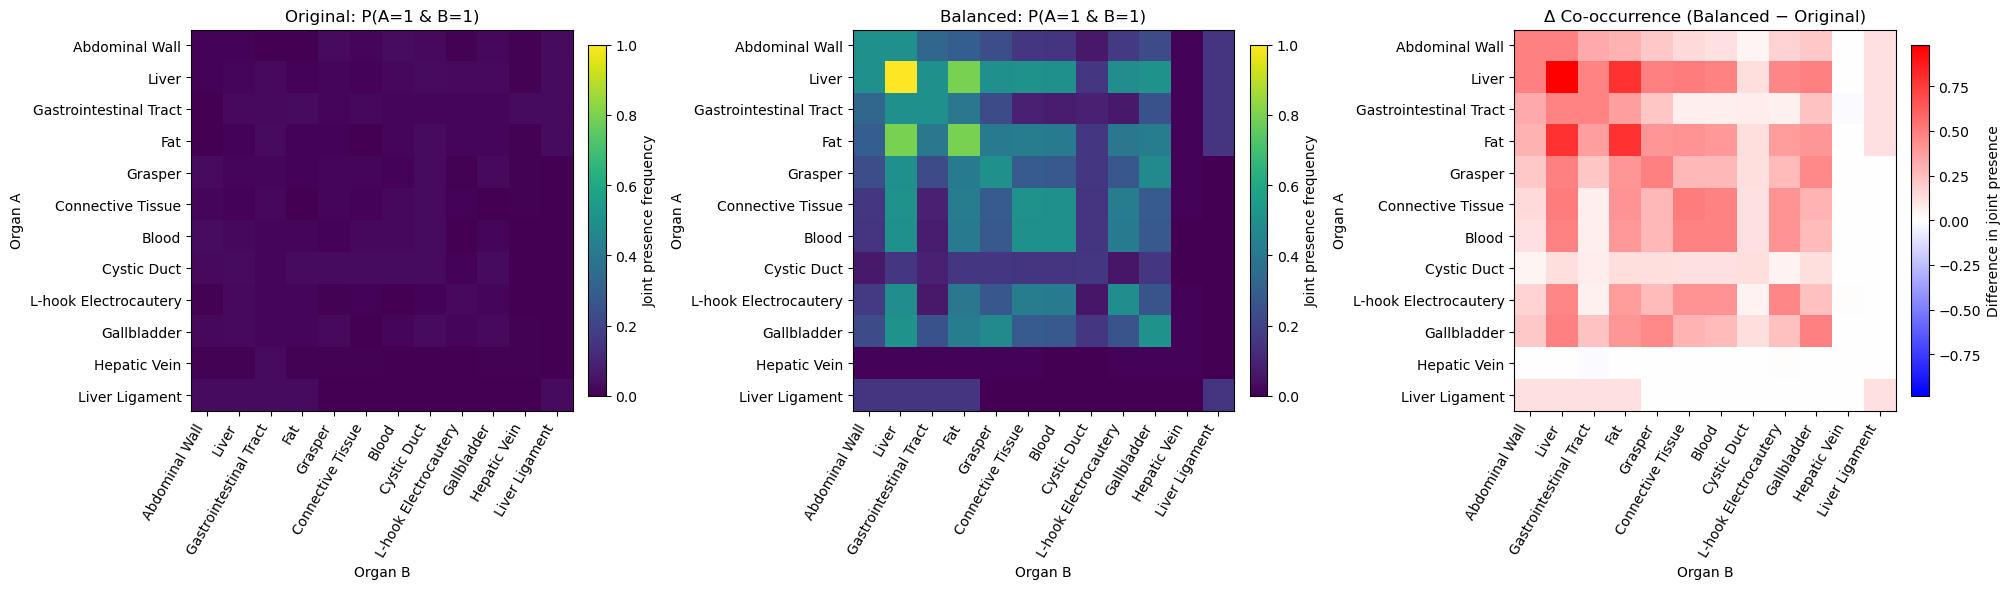

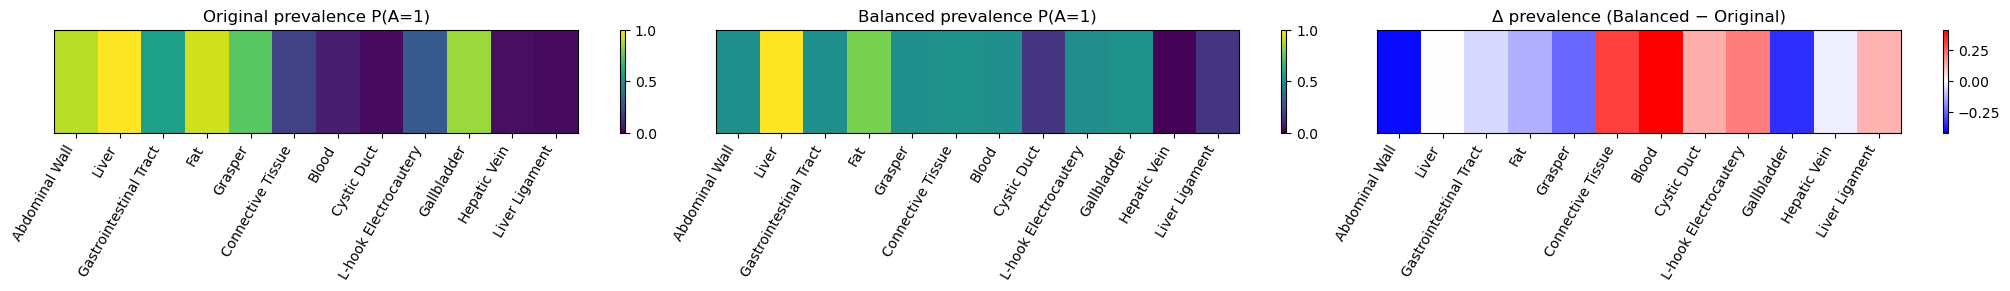

In [17]:
# ===== Co-occurrence heatmaps (original vs balanced) =====
import numpy as np
import matplotlib.pyplot as plt

# Build organ label list in the same order as columns of Y_* (IDs 1..12)
labels = [ID2LABEL[i] for i in sorted(ID2LABEL.keys()) if i != 0]
K = len(labels)

def cooccurrence_matrix(Y: np.ndarray) -> np.ndarray:
    """
    Joint presence frequency P(A=1, B=1) for each organ pair (K x K).
    Y: [N, K] binary presence matrix.
    """
    Yb = (Y > 0).astype(np.uint8)
    N = max(1, Yb.shape[0])
    return (Yb.T @ Yb) / float(N)

# Compute matrices
M_orig = cooccurrence_matrix(Y_orig)  # K x K
M_bal  = cooccurrence_matrix(Y_bal)   # K x K
Delta  = M_bal - M_orig               # change after balancing

# Shared color scales for fair comparison
vmax_joint = float(max(M_orig.max(), M_bal.max()))
vmax_delta = float(np.max(np.abs(Delta))) if Delta.size else 0.0

fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# 1) Original
im0 = axes[0].imshow(M_orig, vmin=0.0, vmax=vmax_joint)
axes[0].set_title("Original: P(A=1 & B=1)")
axes[0].set_xticks(range(K)); axes[0].set_xticklabels(labels, rotation=60, ha='right')
axes[0].set_yticks(range(K)); axes[0].set_yticklabels(labels)
axes[0].set_xlabel("Organ B"); axes[0].set_ylabel("Organ A")
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label("Joint presence frequency")

# 2) Balanced
im1 = axes[1].imshow(M_bal, vmin=0.0, vmax=vmax_joint)
axes[1].set_title("Balanced: P(A=1 & B=1)")
axes[1].set_xticks(range(K)); axes[1].set_xticklabels(labels, rotation=60, ha='right')
axes[1].set_yticks(range(K)); axes[1].set_yticklabels(labels)
axes[1].set_xlabel("Organ B"); axes[1].set_ylabel("Organ A")
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label("Joint presence frequency")

# 3) Delta (Balanced - Original)
if vmax_delta > 0:
    im2 = axes[2].imshow(Delta, vmin=-vmax_delta, vmax=vmax_delta, cmap='bwr')
else:
    im2 = axes[2].imshow(Delta)  # degenerate case, all zeros
axes[2].set_title("Δ Co-occurrence (Balanced − Original)")
axes[2].set_xticks(range(K)); axes[2].set_xticklabels(labels, rotation=60, ha='right')
axes[2].set_yticks(range(K)); axes[2].set_yticklabels(labels)
axes[2].set_xlabel("Organ B"); axes[2].set_ylabel("Organ A")
cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
cbar2.set_label("Difference in joint presence")

plt.show()

# (Optional) also visualize marginal prevalence as a thin "heatmap" bar
p_orig = Y_orig.mean(axis=0)  # per-organ prevalence
p_bal  = Y_bal.mean(axis=0)
fig2, axes2 = plt.subplots(1, 3, figsize=(20, 2.8), constrained_layout=True)

imA = axes2[0].imshow(p_orig[np.newaxis, :], aspect="auto", vmin=0.0, vmax=1.0)
axes2[0].set_title("Original prevalence P(A=1)")
axes2[0].set_yticks([]); axes2[0].set_xticks(range(K)); axes2[0].set_xticklabels(labels, rotation=60, ha='right')
fig2.colorbar(imA, ax=axes2[0], fraction=0.046, pad=0.08)

imB = axes2[1].imshow(p_bal[np.newaxis, :], aspect="auto", vmin=0.0, vmax=1.0)
axes2[1].set_title("Balanced prevalence P(A=1)")
axes2[1].set_yticks([]); axes2[1].set_xticks(range(K)); axes2[1].set_xticklabels(labels, rotation=60, ha='right')
fig2.colorbar(imB, ax=axes2[1], fraction=0.046, pad=0.08)

dP = (p_bal - p_orig)[np.newaxis, :]
v = float(np.max(np.abs(dP)))
if v > 0:
    imC = axes2[2].imshow(dP, aspect="auto", vmin=-v, vmax=v, cmap='bwr')
else:
    imC = axes2[2].imshow(dP, aspect="auto")
axes2[2].set_title("Δ prevalence (Balanced − Original)")
axes2[2].set_yticks([]); axes2[2].set_xticks(range(K)); axes2[2].set_xticklabels(labels, rotation=60, ha='right')
fig2.colorbar(imC, ax=axes2[2], fraction=0.046, pad=0.08)

plt.show()


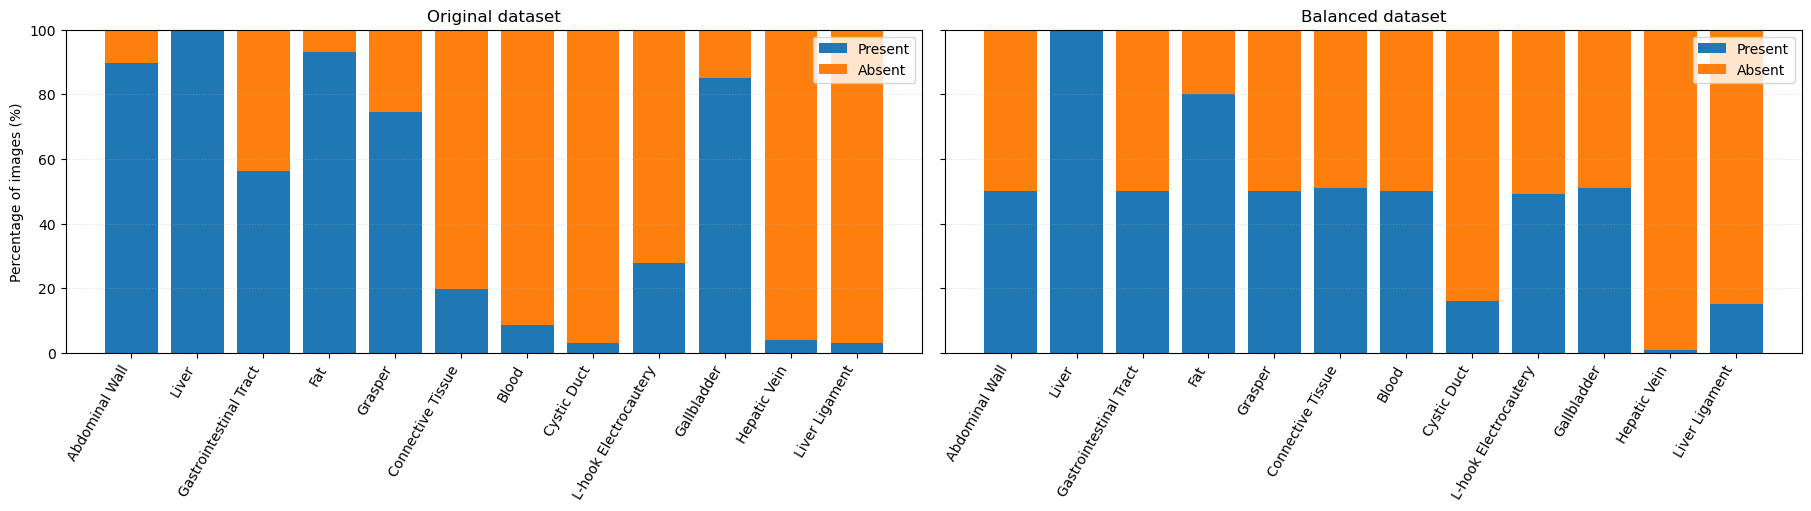

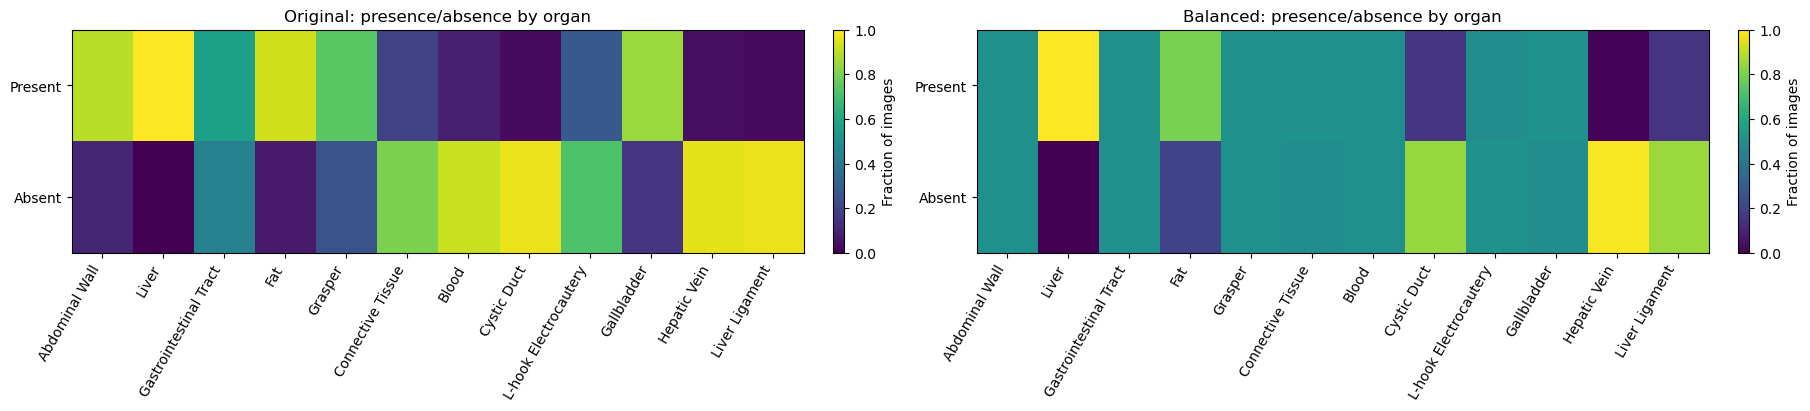


--- Raw counts per organ ---
 1 Abdominal Wall           | Orig: present 7255 / absent  825 || Bal: present   50 / absent   50
 2 Liver                    | Orig: present 8080 / absent    0 || Bal: present  100 / absent    0
 3 Gastrointestinal Tract   | Orig: present 4556 / absent 3524 || Bal: present   50 / absent   50
 4 Fat                      | Orig: present 7510 / absent  570 || Bal: present   80 / absent   20
 5 Grasper                  | Orig: present 6020 / absent 2060 || Bal: present   50 / absent   50
 6 Connective Tissue        | Orig: present 1600 / absent 6480 || Bal: present   51 / absent   49
 7 Blood                    | Orig: present  692 / absent 7388 || Bal: present   50 / absent   50
 8 Cystic Duct              | Orig: present  241 / absent 7839 || Bal: present   16 / absent   84
 9 L-hook Electrocautery    | Orig: present 2251 / absent 5829 || Bal: present   49 / absent   51
10 Gallbladder              | Orig: present 6860 / absent 1220 || Bal: present   51 / ab

In [18]:
# ===== Presence/Absence per organ: stacked bars + heatmaps =====
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have:
# Y_orig: [N_orig, K] binary
# Y_bal : [N_bal , K] binary
# labels: list[str] length K (IDs 1..12)

K = len(labels)

# --- counts & percentages ---
present_orig = Y_orig.sum(axis=0)                # [K]
absent_orig  = Y_orig.shape[0] - present_orig
present_bal  = Y_bal.sum(axis=0)
absent_bal   = Y_bal.shape[0] - present_bal

pct_present_orig = present_orig / np.maximum(1, Y_orig.shape[0])
pct_absent_orig  = 1.0 - pct_present_orig
pct_present_bal  = present_bal / np.maximum(1, Y_bal.shape[0])
pct_absent_bal   = 1.0 - pct_present_bal

# --- stacked bar charts (percent) ---
x = np.arange(K)

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True, constrained_layout=True)

# Original
axes[0].bar(x, pct_present_orig * 100, label="Present")
axes[0].bar(x, pct_absent_orig  * 100, bottom=pct_present_orig * 100, label="Absent")
axes[0].set_title("Original dataset")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=60, ha='right')
axes[0].set_ylabel("Percentage of images (%)")
axes[0].legend(loc="upper right")
axes[0].grid(axis='y', linestyle=':', alpha=0.4)

# Balanced
axes[1].bar(x, pct_present_bal * 100, label="Present")
axes[1].bar(x, pct_absent_bal  * 100, bottom=pct_present_bal * 100, label="Absent")
axes[1].set_title("Balanced dataset")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=60, ha='right')
axes[1].legend(loc="upper right")
axes[1].grid(axis='y', linestyle=':', alpha=0.4)

plt.show()

# --- 2×K heatmaps (rows: Present / Absent) ---
H_orig = np.vstack([pct_present_orig, pct_absent_orig])  # shape (2,K)
H_bal  = np.vstack([pct_present_bal , pct_absent_bal ])
row_labels = ["Present", "Absent"]

vmin, vmax = 0.0, 1.0

fig, axes = plt.subplots(1, 2, figsize=(18, 4), constrained_layout=True)

im0 = axes[0].imshow(H_orig, vmin=vmin, vmax=vmax, aspect='auto')
axes[0].set_title("Original: presence/absence by organ")
axes[0].set_yticks([0,1]); axes[0].set_yticklabels(row_labels)
axes[0].set_xticks(range(K)); axes[0].set_xticklabels(labels, rotation=60, ha='right')
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label("Fraction of images")

im1 = axes[1].imshow(H_bal, vmin=vmin, vmax=vmax, aspect='auto')
axes[1].set_title("Balanced: presence/absence by organ")
axes[1].set_yticks([0,1]); axes[1].set_yticklabels(row_labels)
axes[1].set_xticks(range(K)); axes[1].set_xticklabels(labels, rotation=60, ha='right')
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label("Fraction of images")

plt.show()

# (Optional) print raw counts for quick inspection
print("\n--- Raw counts per organ ---")
for i, name in enumerate(labels):
    print(f"{i+1:2d} {name:<24} | Orig: present {present_orig[i]:4d} / absent {absent_orig[i]:4d} "
          f"|| Bal: present {present_bal[i]:4d} / absent {absent_bal[i]:4d}")
